In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np

plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'grey'
plt.rcParams['grid.color'] = 'lightgrey'
# plt.rcParams['font.weight'] = 'bold'

In [2]:
df_basic_release = pd.read_csv('../independent_metrics/basic_release.csv', index_col='bug_id')
df_basic_beta = pd.read_csv('../independent_metrics/basic_beta.csv', index_col='bug_id')
df_basic_aurora = pd.read_csv('../independent_metrics/basic_aurora.csv', index_col='bug_id')

df_bug_inducing = pd.read_csv('../independent_metrics/bug_inducing.csv', index_col='bug_id')

df_release = pd.merge(df_basic_release, df_bug_inducing, left_index=True, right_index=True)
df_beta = pd.merge(df_basic_beta, df_bug_inducing, left_index=True, right_index=True)
df_aurora = pd.merge(df_basic_aurora, df_bug_inducing, left_index=True, right_index=True)

In [3]:
df_release = df_release[df_release.component != 'Pocket']
df_beta = df_beta[df_beta.component != 'Pocket']
df_aurora = df_aurora[df_aurora.component != 'Pocket']

In [4]:
all_names = pd.concat([pd.DataFrame(df_release.bug_assignee.ravel()), pd.DataFrame(df_beta.bug_assignee.ravel()), pd.DataFrame(df_aurora.bug_assignee.ravel())])
names = pd.unique(all_names[0])
names = pd.Series(np.arange(len(names)), names)

df_release.bug_assignee = df_release.bug_assignee.map(names.get)
df_beta.bug_assignee = df_beta.bug_assignee.map(names.get)
df_aurora.bug_assignee = df_aurora.bug_assignee.map(names.get)

In [5]:
df_release.shape

(285, 33)

In [6]:
df_beta.shape

(2614, 33)

In [7]:
df_aurora.shape

(4368, 33)

In [8]:
df_release.component = df_release.component.apply(lambda x: x.split(':')[0])
df_beta.component = df_beta.component.apply(lambda x: x.split(':')[0])
df_aurora.component = df_aurora.component.apply(lambda x: x.split(':')[0])

In [9]:
df_release_accepted = df_release[df_release['uplift_accepted'] == True]
df_beta_accepted = df_beta[df_beta['uplift_accepted'] == True]
df_aurora_accepted = df_aurora[df_aurora['uplift_accepted'] == True]

In [10]:
df_release_accepted.shape

(229, 33)

In [11]:
df_beta_accepted.shape

(2386, 33)

In [12]:
df_aurora_accepted.shape

(4306, 33)

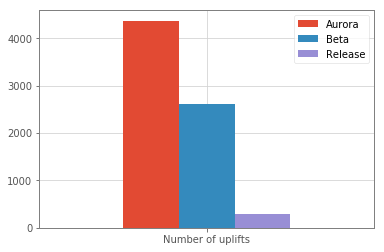

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
pd.DataFrame({'Release': len(df_release), 'Beta': len(df_beta), 'Aurora': len(df_aurora)}, index=['Number of uplifts']).plot.bar(grid=True, ax=ax)
plt.xticks(rotation=0)
plt.show()
fig.savefig('uplifts_per_channel.pdf', format='pdf', bbox_inches='tight')

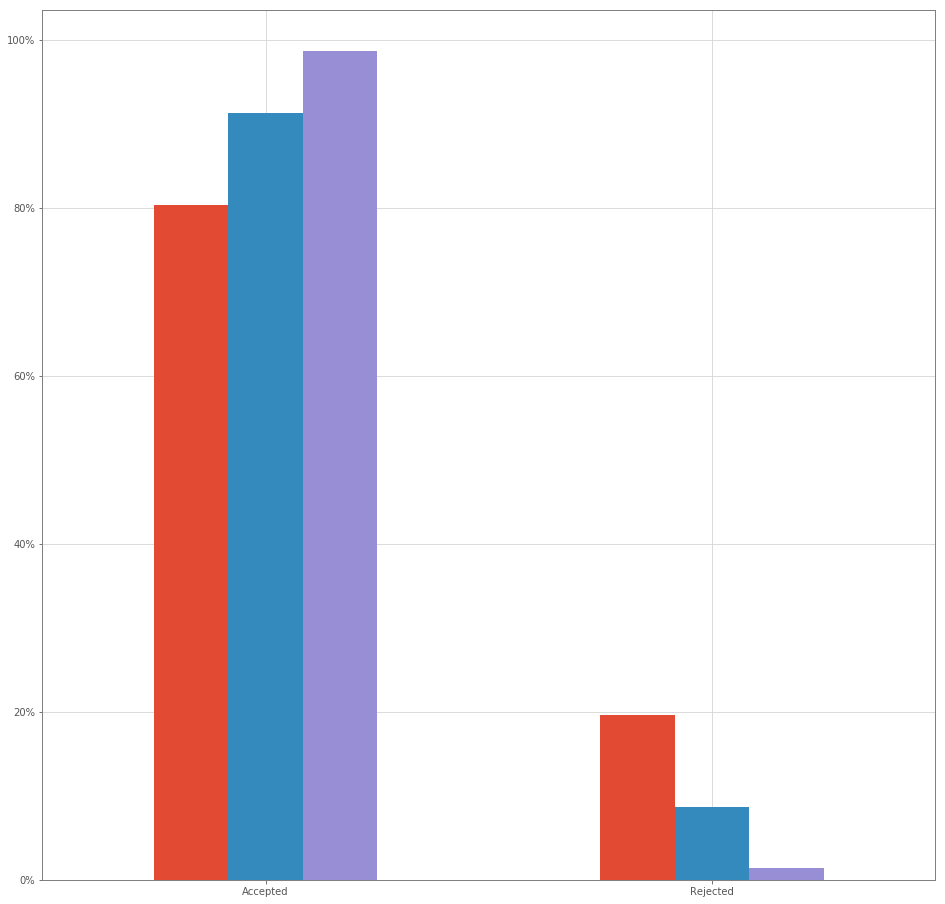

In [14]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
pd.concat([df_release['uplift_accepted'].value_counts(normalize=True).rename('Release'), df_beta['uplift_accepted'].value_counts(normalize=True).rename('Beta'), df_aurora['uplift_accepted'].value_counts(normalize=True).rename('Aurora')], axis=1)\
.plot(kind='bar', ax=ax, legend=False)
ax.set_xticklabels(['Accepted', 'Rejected'])
plt.xticks(rotation=0)
plt.show()
fig.savefig('accepted_channels.pdf', format='pdf', bbox_inches='tight')

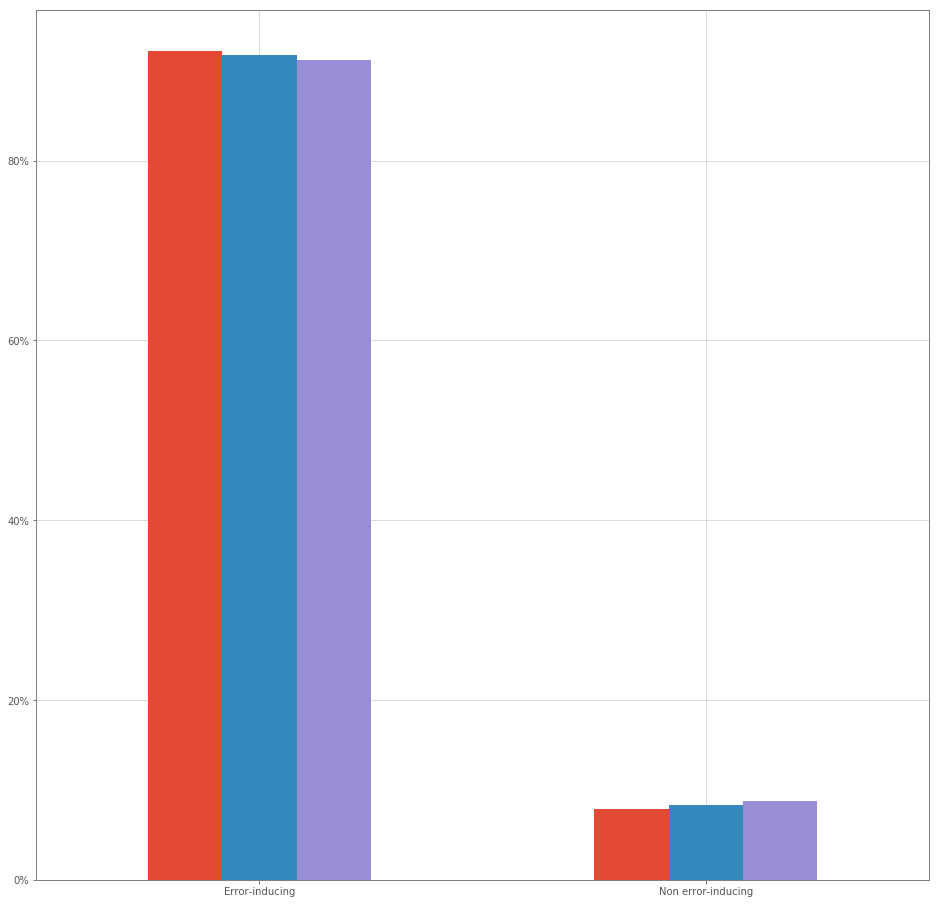

In [15]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
pd.concat([df_release_accepted['error_inducing'].value_counts(normalize=True).rename('Release'), df_beta_accepted['error_inducing'].value_counts(normalize=True).rename('Beta'), df_aurora_accepted['error_inducing'].value_counts(normalize=True).rename('Aurora')], axis=1)\
.plot(kind='bar', ax=ax, legend=False)
ax.set_xticklabels(['Error-inducing', 'Non error-inducing'])
plt.xticks(rotation=0)
plt.show()
fig.savefig('error_inducing_channels.pdf', format='pdf', bbox_inches='tight')

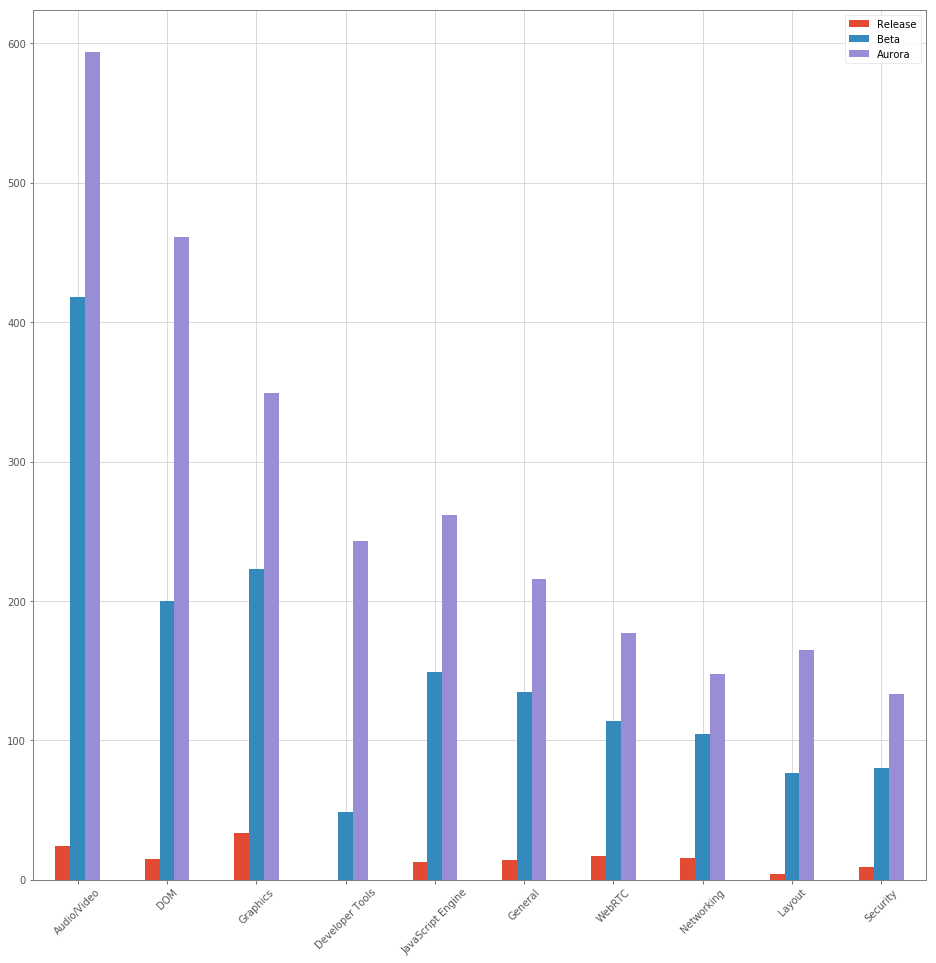

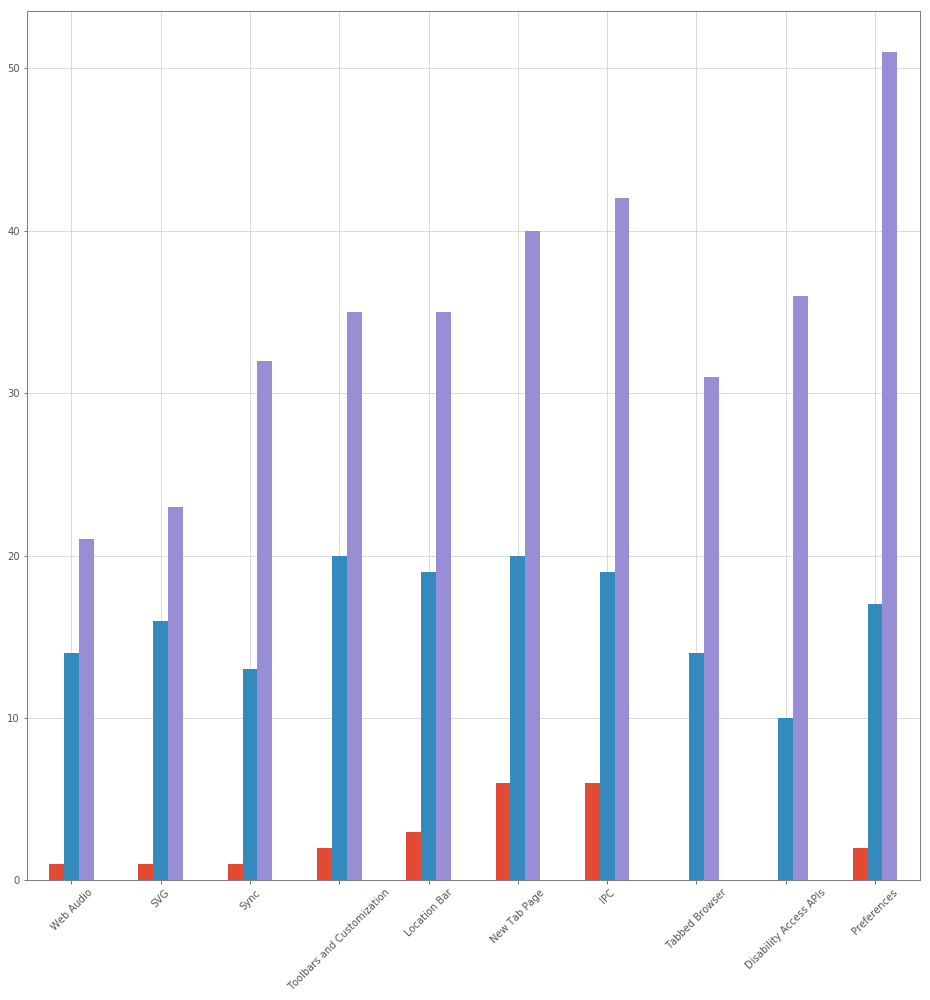

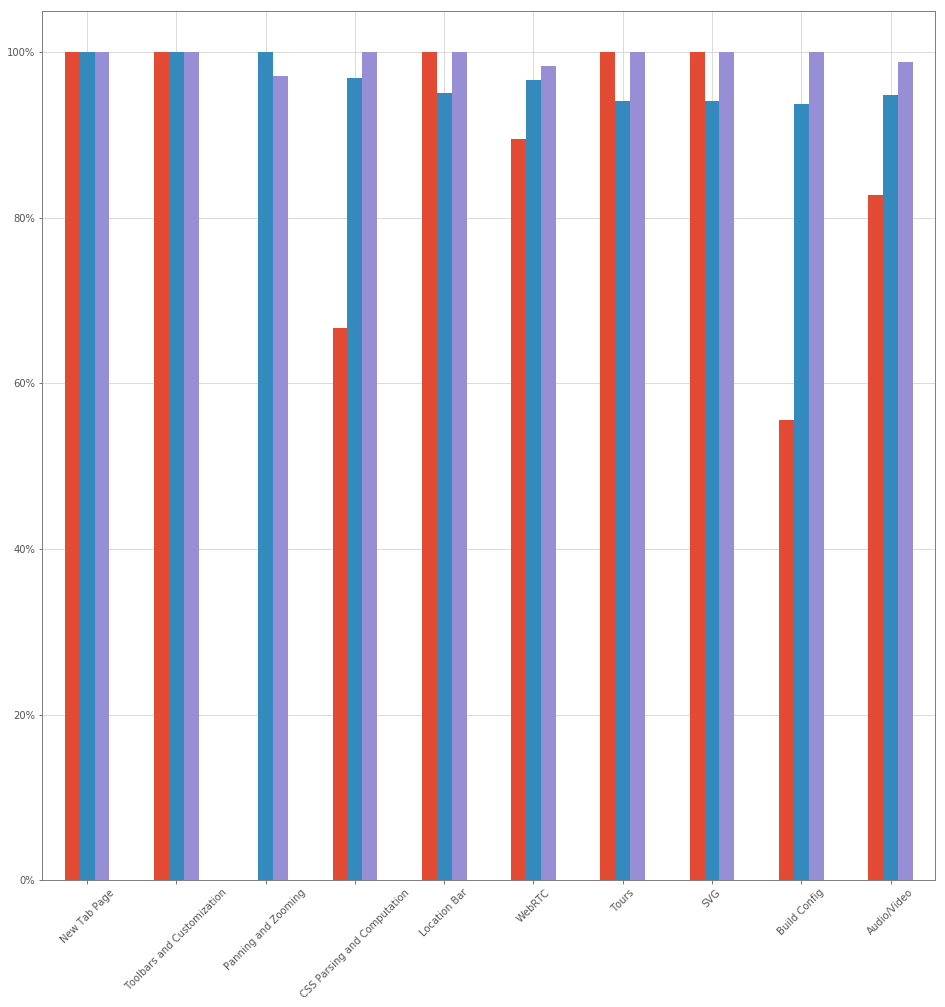

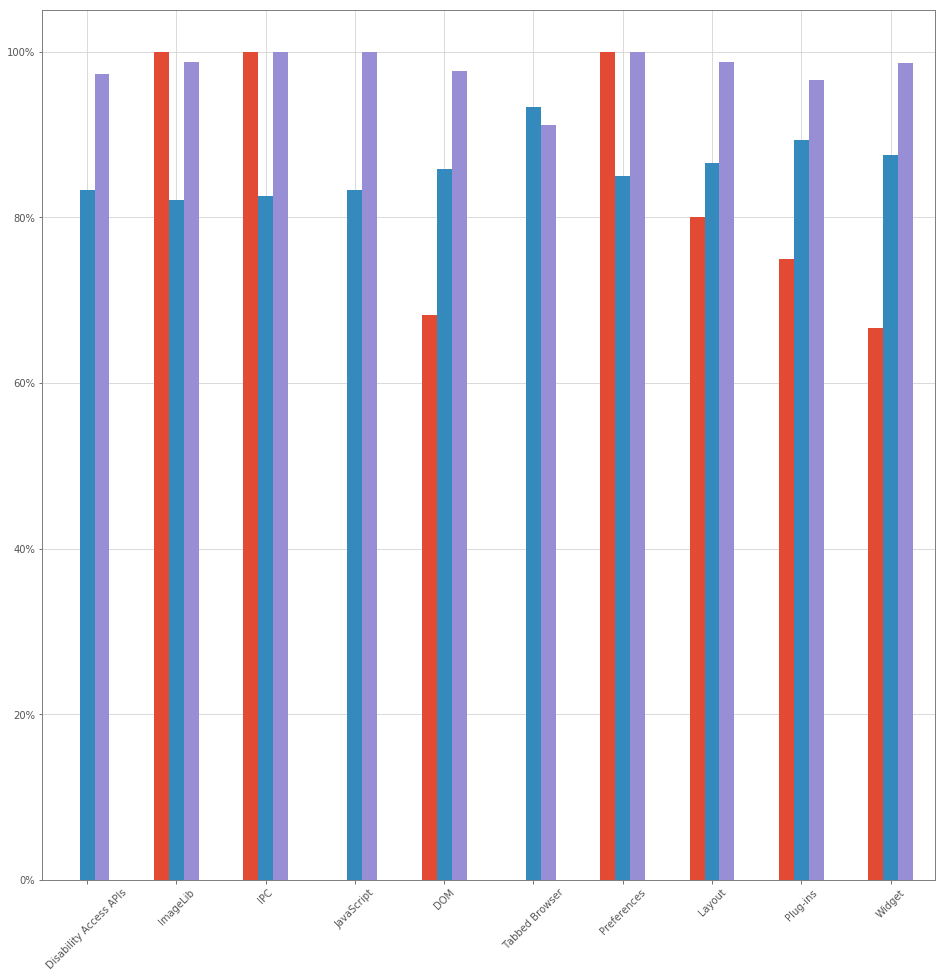

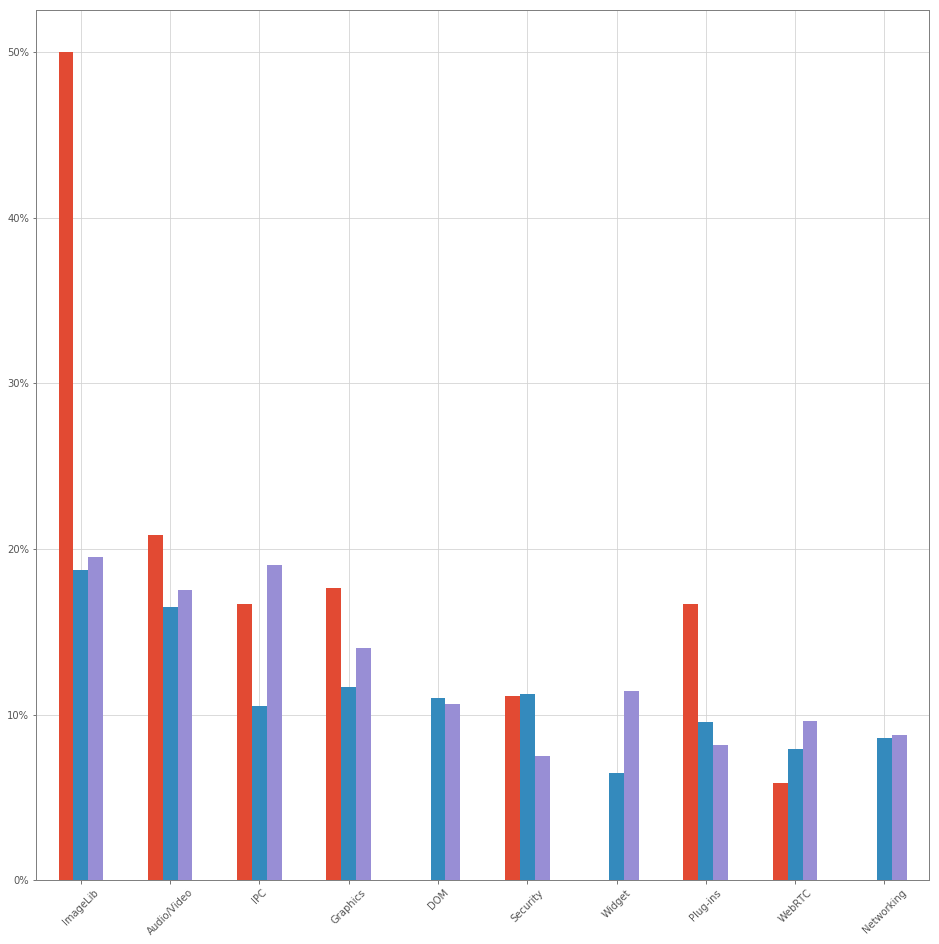

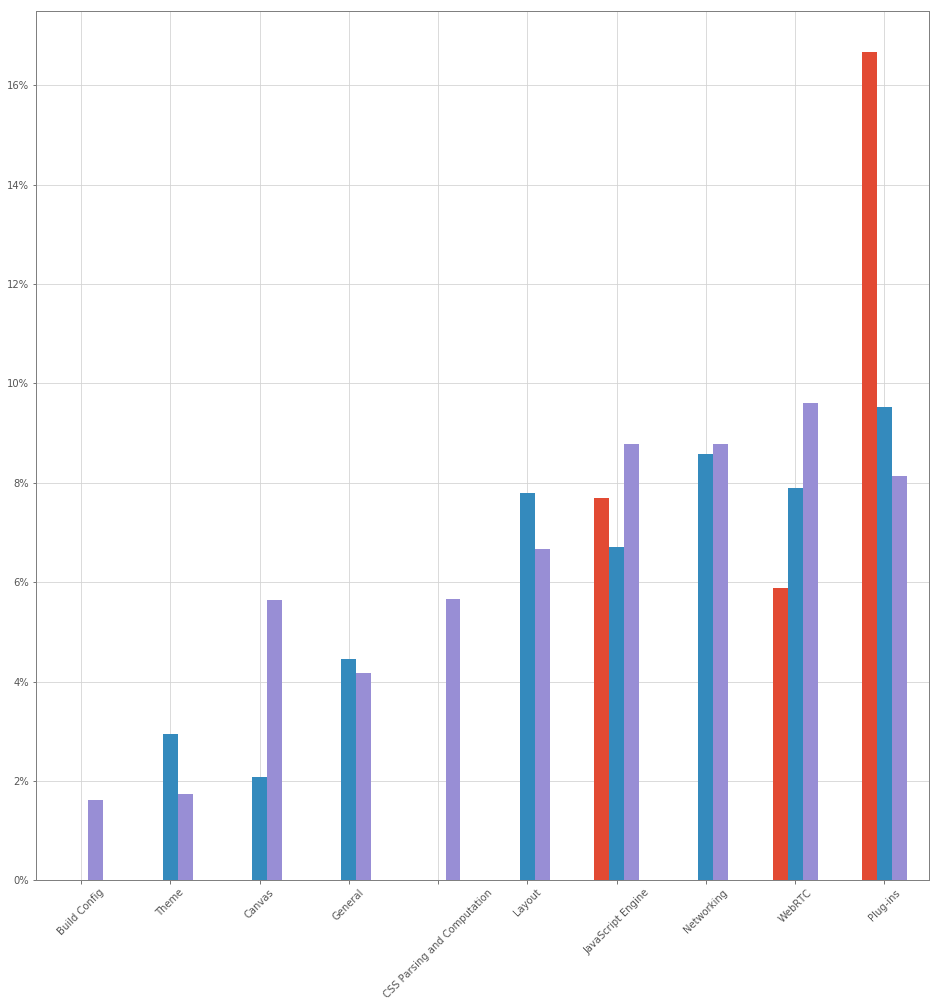

In [16]:
res1 = df_release[df_release['uplift_accepted'] == True].component.value_counts()
res1.name = 'release'
res2 = df_beta[df_beta['uplift_accepted'] == True].component.value_counts()
res2.name = 'beta'
res3 = df_aurora[df_aurora['uplift_accepted'] == True].component.value_counts()
res3.name = 'aurora'

res = pd.concat([res1, res2, res3], axis=1)

res['release_requests'] = df_release.component.value_counts()
res['beta_requests'] = df_beta.component.value_counts()
res['aurora_requests'] = df_aurora.component.value_counts()
res['release_rate'] = res['release'] / res['release_requests']
res['beta_rate'] = res['beta'] / res['beta_requests']
res['aurora_rate'] = res['aurora'] / res['aurora_requests']

res = res[(res.beta_requests > 10) & (res.aurora_requests > 20)]

res['rate_sort_val'] = res.apply(lambda x: np.nanmean([x['beta_rate'], x['aurora_rate']]), axis=1)
res['total_sort_val'] = res.apply(lambda x: np.nanmean([x['release'], x['beta'], x['aurora']]), axis=1)

# Components where the highest number of patches are uplifted.
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
res\
.sort_values(['total_sort_val', 'release', 'beta', 'aurora'], ascending=False)[['release', 'beta', 'aurora']]\
.rename(index=str, columns={'release': 'Release', 'beta': 'Beta', 'aurora': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax)
plt.xticks(rotation=45)
plt.show()
fig.savefig('per_component_a.pdf', format='pdf', bbox_inches='tight')

# Components where the least number of patches are uplifted.
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
res\
.sort_values(['total_sort_val', 'beta', 'aurora', 'release'], ascending=[True, False, False, False])[['release', 'beta', 'aurora']]\
.rename(index=str, columns={'release': 'Release', 'beta': 'Beta', 'aurora': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax, legend=False)
plt.xticks(rotation=45)
plt.show()
fig.savefig('per_component_b.pdf', format='pdf', bbox_inches='tight')

# Components where the acceptance rate is higher.
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res\
.sort_values(['rate_sort_val', 'beta_requests', 'aurora_requests', 'release_requests'], ascending=False)[['release_rate', 'beta_rate', 'aurora_rate']]\
.rename(index=str, columns={'release_rate': 'Release', 'beta_rate': 'Beta', 'aurora_rate': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax, legend=False)
plt.xticks(rotation=45)
plt.show()
fig.savefig('per_component_c.pdf', format='pdf', bbox_inches='tight')

# Components where the acceptance rate is lower.
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res\
.sort_values(['rate_sort_val', 'beta_requests', 'aurora_requests', 'release_requests'], ascending=[True, False, False, False])[['release_rate', 'beta_rate', 'aurora_rate']]\
.rename(index=str, columns={'release_rate': 'Release', 'beta_rate': 'Beta', 'aurora_rate': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax, legend=False)
plt.xticks(rotation=45)
plt.show()
fig.savefig('per_component_d.pdf', format='pdf', bbox_inches='tight')

res1 = df_release_accepted[df_release_accepted['error_inducing'] == True].component.value_counts()
res1.name = 'release'
res2 = df_beta_accepted[df_beta_accepted['error_inducing'] == True].component.value_counts()
res2.name = 'beta'
res3 = df_aurora_accepted[df_aurora_accepted['error_inducing'] == True].component.value_counts()
res3.name = 'aurora'

res = pd.concat([res1, res2, res3], axis=1)

res['release_accepted'] = df_release_accepted.component.value_counts()
res['beta_accepted'] = df_beta_accepted.component.value_counts()
res['aurora_accepted'] = df_aurora_accepted.component.value_counts()
res['release_rate'] = res['release'] / res['release_accepted']
res['beta_rate'] = res['beta'] / res['beta_accepted']
res['aurora_rate'] = res['aurora'] / res['aurora_accepted']

res = res[(res.release_accepted > 1) & (res.beta_accepted > 10) & (res.aurora_accepted > 20)]

res['rate_sort_val'] = res.apply(lambda x: np.nanmean([x['beta_rate'], x['aurora_rate']]), axis=1)

# Components where the error inducing rate is higher.
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res\
.sort_values(['rate_sort_val', 'beta_accepted', 'aurora_accepted', 'release_accepted'], ascending=False)[['release_rate', 'beta_rate', 'aurora_rate']]\
.rename(index=str, columns={'release_rate': 'Release', 'beta_rate': 'Beta', 'aurora_rate': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax, legend=False)
plt.xticks(rotation=45)
plt.show()
fig.savefig('per_component_e.pdf', format='pdf', bbox_inches='tight')

# Components where the error inducing rate is lower.
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res\
.sort_values(['rate_sort_val', 'beta_accepted', 'aurora_accepted', 'release_accepted'], ascending=[True, False, False, False])[['release_rate', 'beta_rate', 'aurora_rate']]\
.rename(index=str, columns={'release_rate': 'Release', 'beta_rate': 'Beta', 'aurora_rate': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax, legend=False)
plt.xticks(rotation=45)
plt.show()
fig.savefig('per_component_f.pdf', format='pdf', bbox_inches='tight')

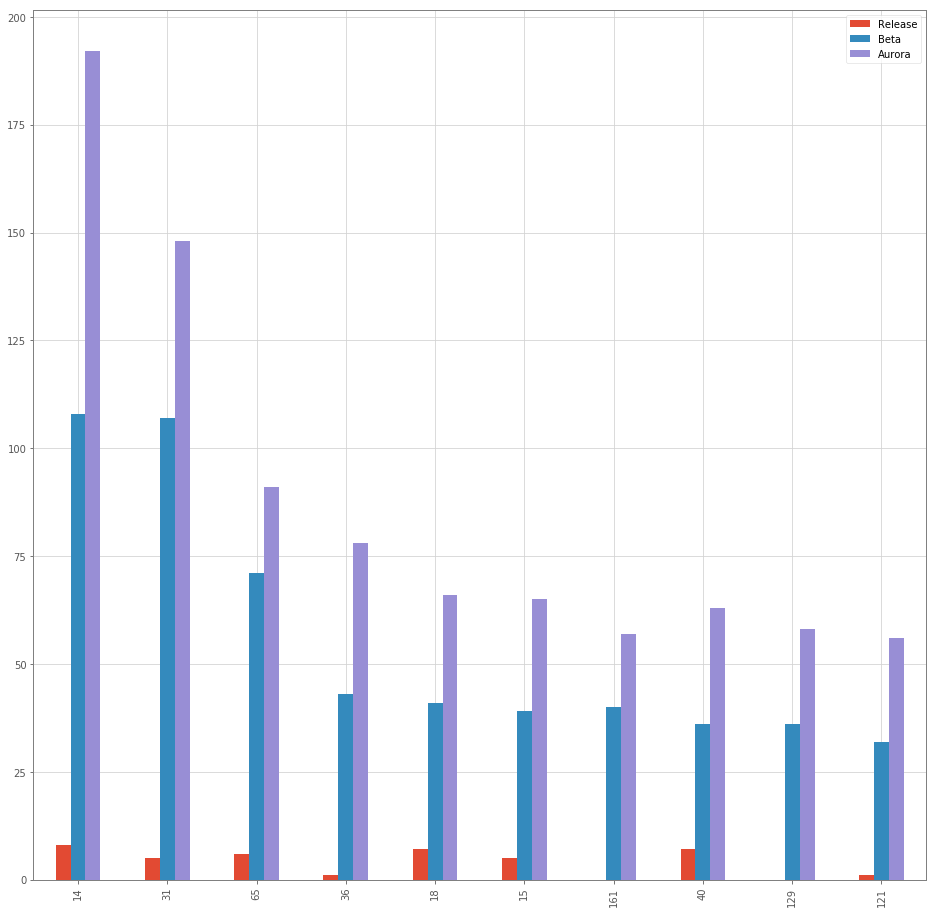

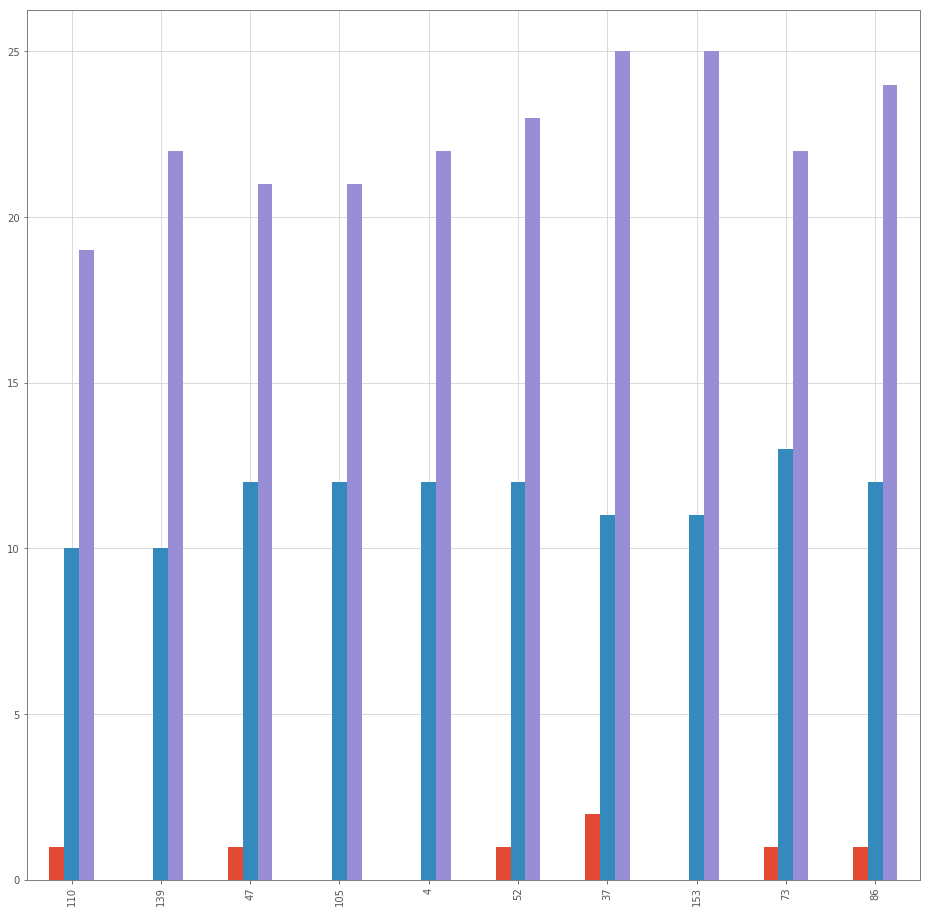

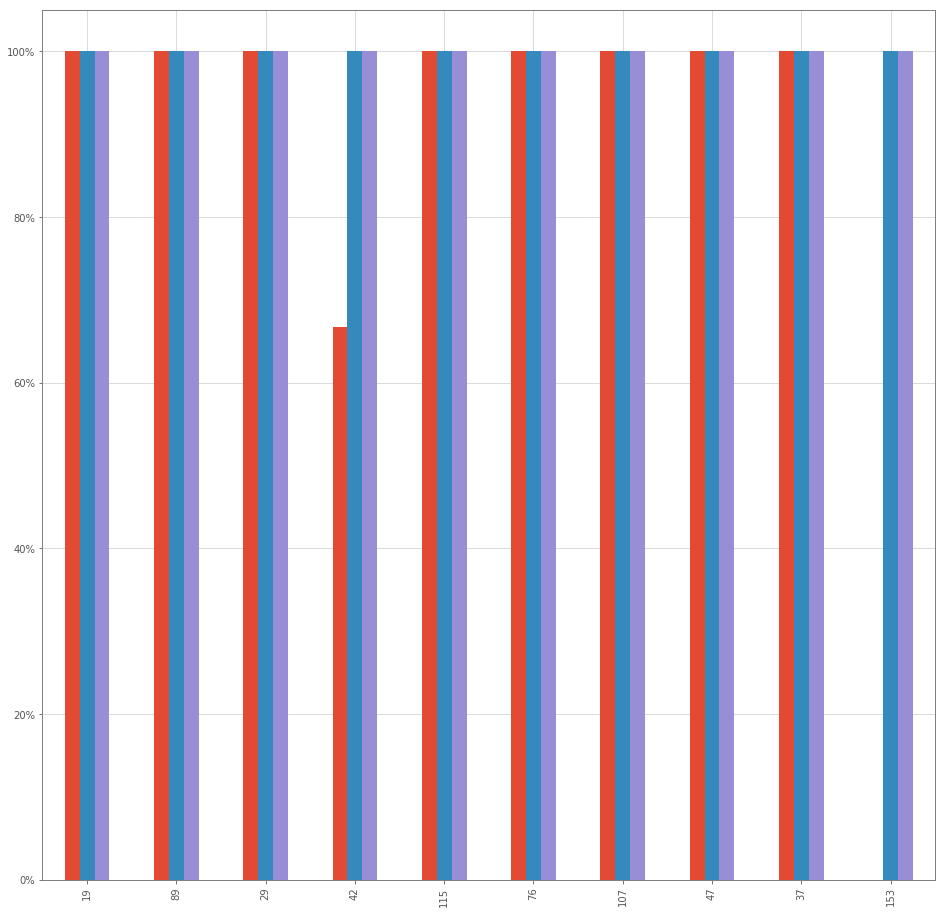

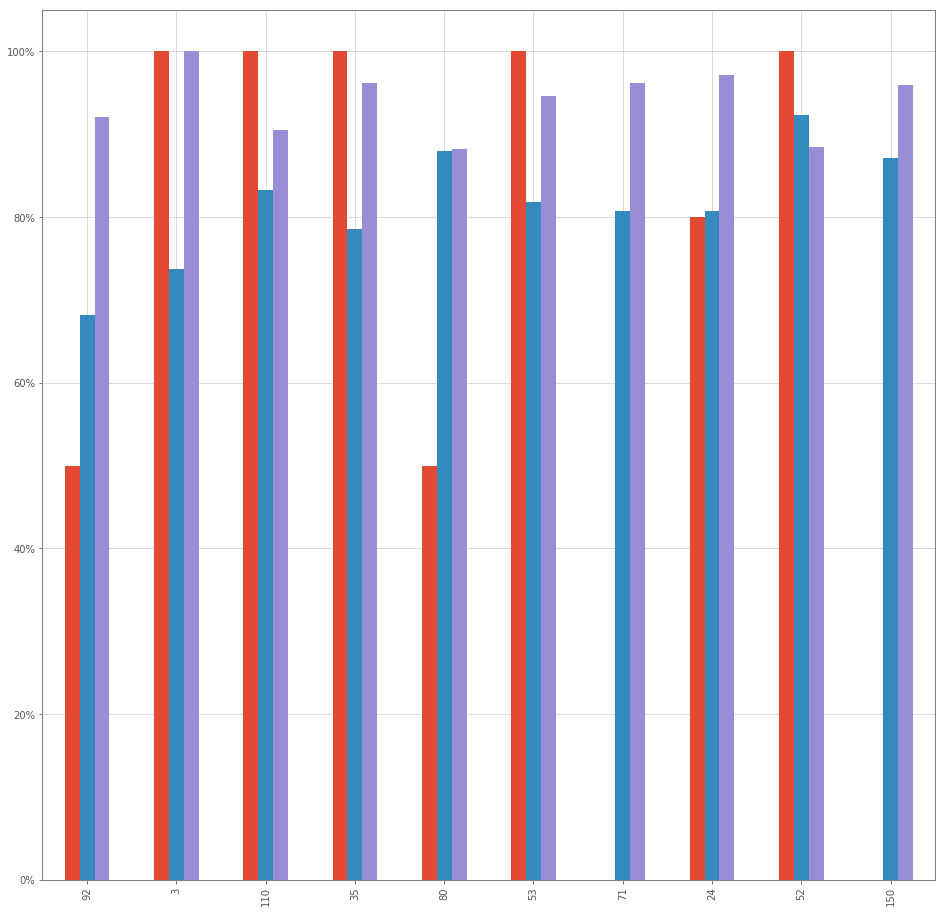

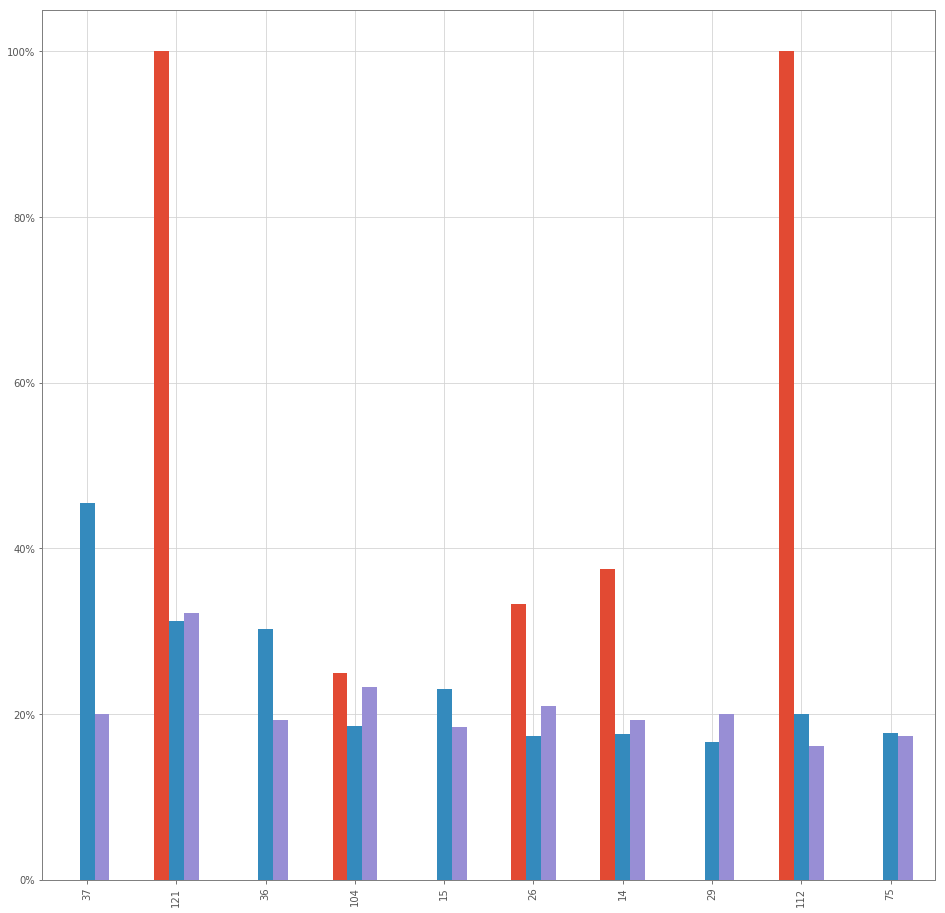

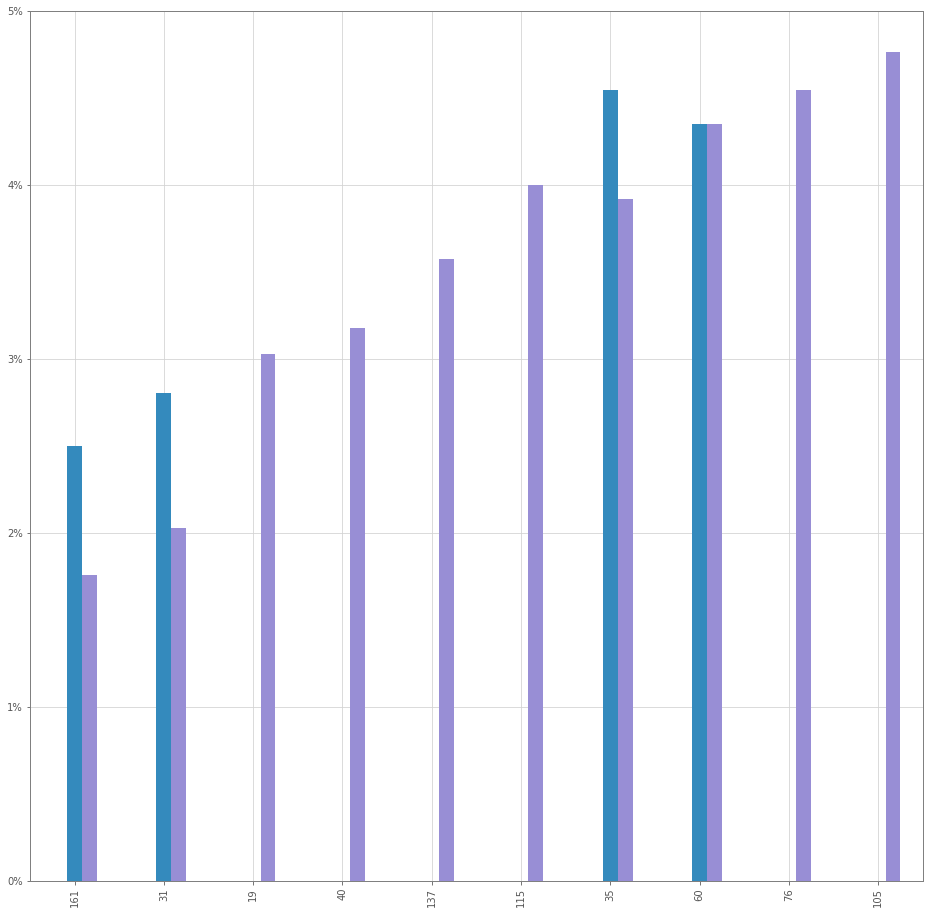

In [17]:
res1 = df_release[df_release['uplift_accepted'] == True].bug_assignee.value_counts()
res1.name = 'release'
res2 = df_beta[df_beta['uplift_accepted'] == True].bug_assignee.value_counts()
res2.name = 'beta'
res3 = df_aurora[df_aurora['uplift_accepted'] == True].bug_assignee.value_counts()
res3.name = 'aurora'

res = pd.concat([res1, res2, res3], axis=1)

res['release_requests'] = df_release.bug_assignee.value_counts()
res['beta_requests'] = df_beta.bug_assignee.value_counts()
res['aurora_requests'] = df_aurora.bug_assignee.value_counts()
res['release_rate'] = res['release'] / res['release_requests']
res['beta_rate'] = res['beta'] / res['beta_requests']
res['aurora_rate'] = res['aurora'] / res['aurora_requests']

res = res[(res.beta_requests > 10) & (res.aurora_requests > 20)]

res['rate_sort_val'] = res.apply(lambda x: np.nanmean([x['beta_rate'], x['aurora_rate']]), axis=1)
res['total_sort_val'] = res.apply(lambda x: np.nanmean([2 * x['beta'], x['aurora']]), axis=1)

# bug_assignees where the highest number of patches are uplifted.
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
res\
.sort_values(['total_sort_val', 'beta', 'aurora'], ascending=False)[['release', 'beta', 'aurora']]\
.rename(index=str, columns={'release': 'Release', 'beta': 'Beta', 'aurora': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax)
plt.xticks(rotation=90)
plt.show()
fig.savefig('per_bug_assignee_a.pdf', format='pdf', bbox_inches='tight')

# bug_assignees where the least number of patches are uplifted.
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
res\
.sort_values(['total_sort_val', 'beta', 'aurora'], ascending=[True, False, False])[['release', 'beta', 'aurora']]\
.rename(index=str, columns={'release': 'Release', 'beta': 'Beta', 'aurora': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax, legend=False)
plt.xticks(rotation=90)
plt.show()
fig.savefig('per_bug_assignee_b.pdf', format='pdf', bbox_inches='tight')

# bug_assignees where the acceptance rate is higher.
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res\
.sort_values(['rate_sort_val', 'beta_requests', 'aurora_requests'], ascending=False)[['release_rate', 'beta_rate', 'aurora_rate']]\
.rename(index=str, columns={'release_rate': 'Release', 'beta_rate': 'Beta', 'aurora_rate': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax, legend=False)
plt.xticks(rotation=90)
plt.show()
fig.savefig('per_bug_assignee_c.pdf', format='pdf', bbox_inches='tight')

# bug_assignees where the acceptance rate is lower.
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res\
.sort_values(['rate_sort_val', 'beta_requests', 'aurora_requests'], ascending=[True, False, False])[['release_rate', 'beta_rate', 'aurora_rate']]\
.rename(index=str, columns={'release_rate': 'Release', 'beta_rate': 'Beta', 'aurora_rate': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax, legend=False)
plt.xticks(rotation=90)
plt.show()
fig.savefig('per_bug_assignee_d.pdf', format='pdf', bbox_inches='tight')

res1 = df_release_accepted[df_release_accepted['error_inducing'] == True].bug_assignee.value_counts()
res1.name = 'release'
res2 = df_beta_accepted[df_beta_accepted['error_inducing'] == True].bug_assignee.value_counts()
res2.name = 'beta'
res3 = df_aurora_accepted[df_aurora_accepted['error_inducing'] == True].bug_assignee.value_counts()
res3.name = 'aurora'

res = pd.concat([res1, res2, res3], axis=1)

res['release_accepted'] = df_release_accepted.bug_assignee.value_counts()
res['beta_accepted'] = df_beta_accepted.bug_assignee.value_counts()
res['aurora_accepted'] = df_aurora_accepted.bug_assignee.value_counts()
res['release_rate'] = res['release'] / res['release_accepted']
res['beta_rate'] = res['beta'] / res['beta_accepted']
res['aurora_rate'] = res['aurora'] / res['aurora_accepted']

res = res[(res.beta_accepted > 10) & (res.aurora_accepted > 20)]

res['rate_sort_val'] = res.apply(lambda x: np.nanmean([x['beta_rate'], x['aurora_rate']]), axis=1)

# bug_assignees where the error inducing rate is higher.
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res\
.sort_values(['rate_sort_val', 'beta_accepted', 'aurora_accepted'], ascending=False)[['release_rate', 'beta_rate', 'aurora_rate']]\
.rename(index=str, columns={'release_rate': 'Release', 'beta_rate': 'Beta', 'aurora_rate': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax, legend=False)
plt.xticks(rotation=90)
plt.show()
fig.savefig('per_bug_assignee_e.pdf', format='pdf', bbox_inches='tight')

# bug_assignees where the error inducing rate is lower.
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res\
.sort_values(['rate_sort_val', 'beta_accepted', 'aurora_accepted'], ascending=[True, False, False])[['release_rate', 'beta_rate', 'aurora_rate']]\
.rename(index=str, columns={'release_rate': 'Release', 'beta_rate': 'Beta', 'aurora_rate': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax, legend=False)
plt.xticks(rotation=90)
plt.show()
fig.savefig('per_bug_assignee_f.pdf', format='pdf', bbox_inches='tight')

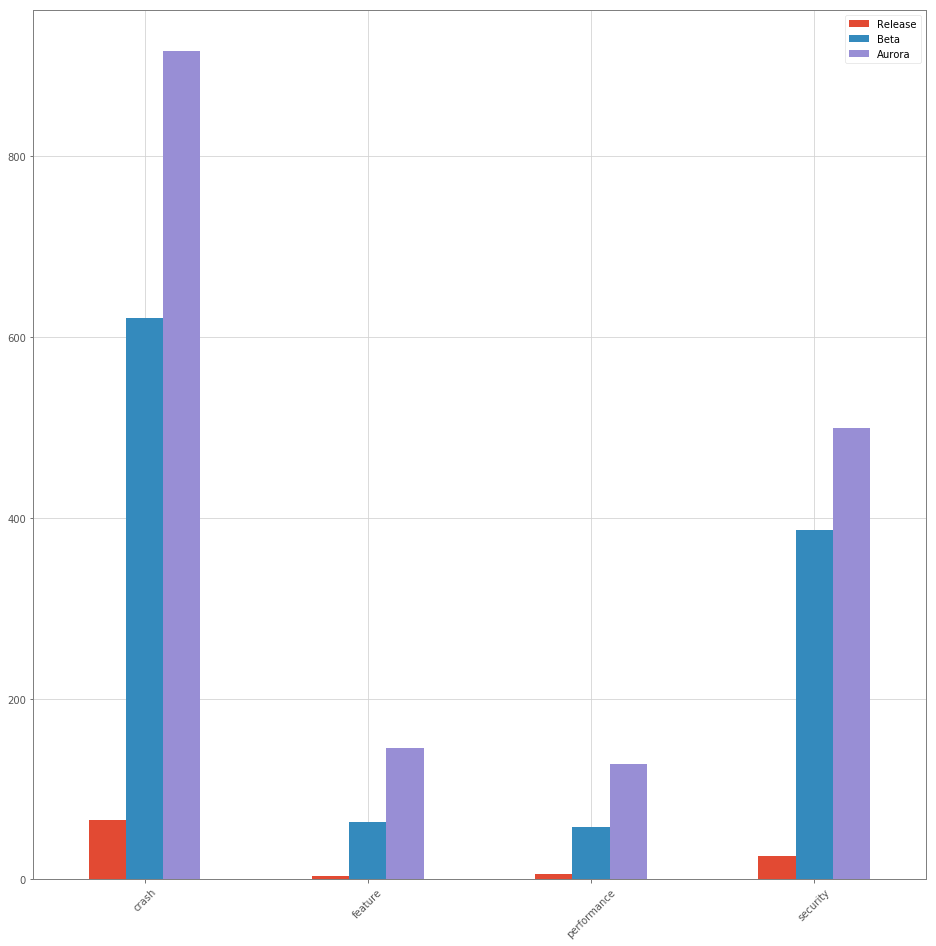

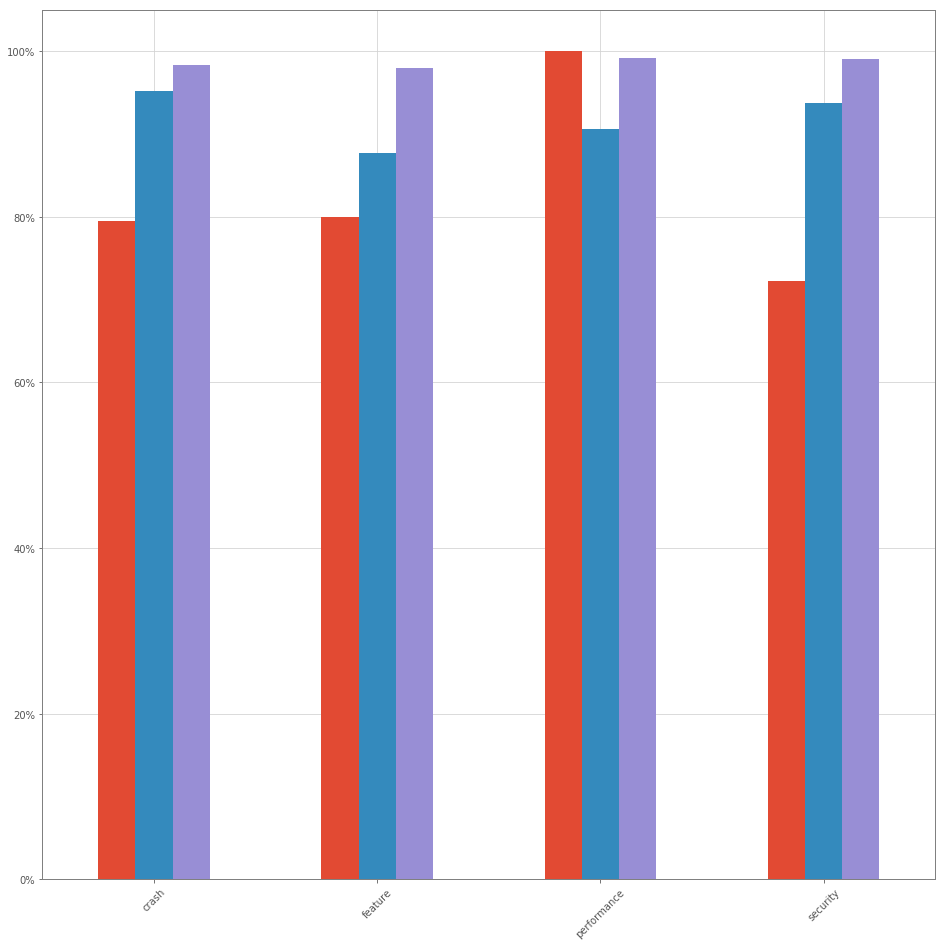

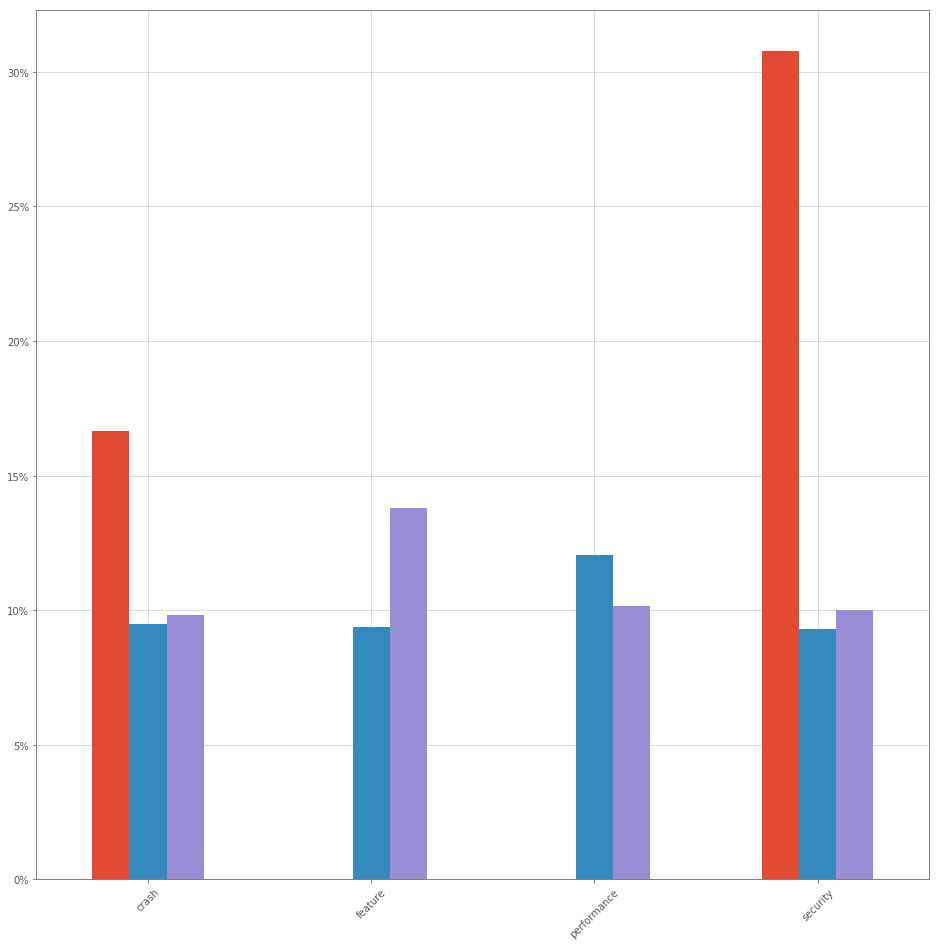

In [18]:
types_release = df_release.types.str.split('^').apply(pd.Series, 1).stack()
types_release.index = types_release.index.droplevel(-1)
types_approved_release = df_release[df_release['uplift_accepted'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_approved_release.index = types_approved_release.index.droplevel(-1)
types_beta = df_beta.types.str.split('^').apply(pd.Series, 1).stack()
types_beta.index = types_beta.index.droplevel(-1)
types_approved_beta = df_beta[df_beta['uplift_accepted'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_approved_beta.index = types_approved_beta.index.droplevel(-1)
types_aurora = df_aurora.types.str.split('^').apply(pd.Series, 1).stack()
types_aurora.index = types_aurora.index.droplevel(-1)
types_approved_aurora = df_aurora[df_aurora['uplift_accepted'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_approved_aurora.index = types_approved_aurora.index.droplevel(-1)
types_error_inducing_release = df_release_accepted[df_release_accepted['error_inducing'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_error_inducing_release.index = types_error_inducing_release.index.droplevel(-1)
types_error_inducing_beta = df_beta_accepted[df_beta_accepted['error_inducing'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_error_inducing_beta.index = types_error_inducing_beta.index.droplevel(-1)
types_error_inducing_aurora = df_aurora_accepted[df_aurora_accepted['error_inducing'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_error_inducing_aurora.index = types_error_inducing_aurora.index.droplevel(-1)

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
pd.concat([(types_approved_release.value_counts()).rename('Release'), (types_approved_beta.value_counts()).rename('Beta'), (types_approved_aurora.value_counts()).rename('Aurora')], axis=1)\
.plot(kind='bar', ax=ax)
plt.xticks(rotation=45)
plt.show()
fig.savefig('uplifts_per_type_and_channel_a.pdf', format='pdf')

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
pd.concat([(types_approved_release.value_counts() / types_release.value_counts()).rename('Release'), (types_approved_beta.value_counts() / types_beta.value_counts()).rename('Beta'), (types_approved_aurora.value_counts() / types_aurora.value_counts()).rename('Aurora')], axis=1)\
.plot(kind='bar', ax=ax, legend=False)
plt.xticks(rotation=45)
plt.show()
fig.savefig('uplifts_per_type_and_channel_b.pdf', format='pdf')

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
pd.concat([(types_error_inducing_release.value_counts() / types_approved_release.value_counts()).rename('Release'), (types_error_inducing_beta.value_counts() / types_approved_beta.value_counts()).rename('Beta'), (types_error_inducing_aurora.value_counts() / types_approved_aurora.value_counts()).rename('Aurora')], axis=1)\
.plot(kind='bar', ax=ax, legend=False)
plt.xticks(rotation=45)
plt.show()
fig.savefig('uplifts_per_type_and_channel_c.pdf', format='pdf')

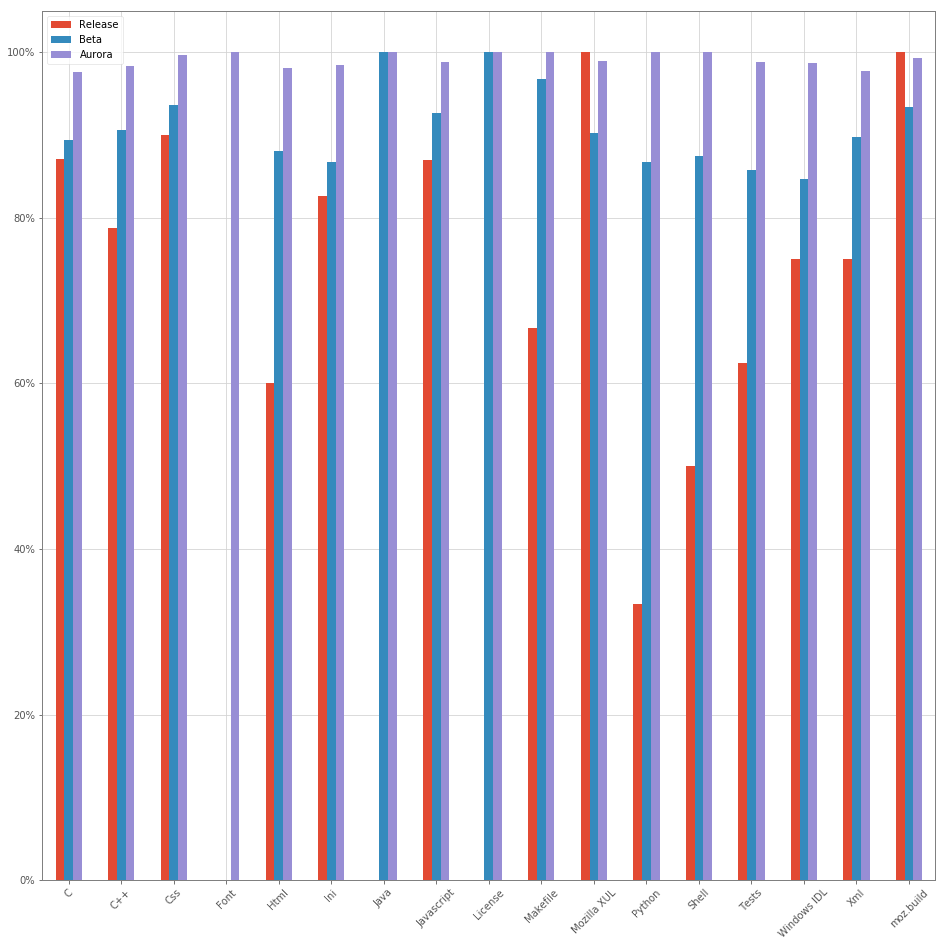

In [19]:
languages_release = df_release.languages.str.split('^').apply(pd.Series, 1).stack()
languages_release.index = languages_release.index.droplevel(-1)
languages_approved_release = df_release[df_release['uplift_accepted'] == True].languages.str.split('^').apply(pd.Series, 1).stack()
languages_approved_release.index = languages_approved_release.index.droplevel(-1)
languages_beta = df_beta.languages.str.split('^').apply(pd.Series, 1).stack()
languages_beta.index = languages_beta.index.droplevel(-1)
languages_approved_beta = df_beta[df_beta['uplift_accepted'] == True].languages.str.split('^').apply(pd.Series, 1).stack()
languages_approved_beta.index = languages_approved_beta.index.droplevel(-1)
languages_aurora = df_aurora.languages.str.split('^').apply(pd.Series, 1).stack()
languages_aurora.index = languages_aurora.index.droplevel(-1)
languages_approved_aurora = df_aurora[df_aurora['uplift_accepted'] == True].languages.str.split('^').apply(pd.Series, 1).stack()
languages_approved_aurora.index = languages_approved_aurora.index.droplevel(-1)

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
pd.concat([(languages_approved_release.value_counts() / languages_release.value_counts()).rename('Release'), (languages_approved_beta.value_counts() / languages_beta.value_counts()).rename('Beta'), (languages_approved_aurora.value_counts() / languages_aurora.value_counts()).rename('Aurora')], axis=1)\
.plot(kind='bar', ax=ax)
plt.xticks(rotation=45)
plt.show()

## Release uplifts

### Approved vs rejected uplifts per component

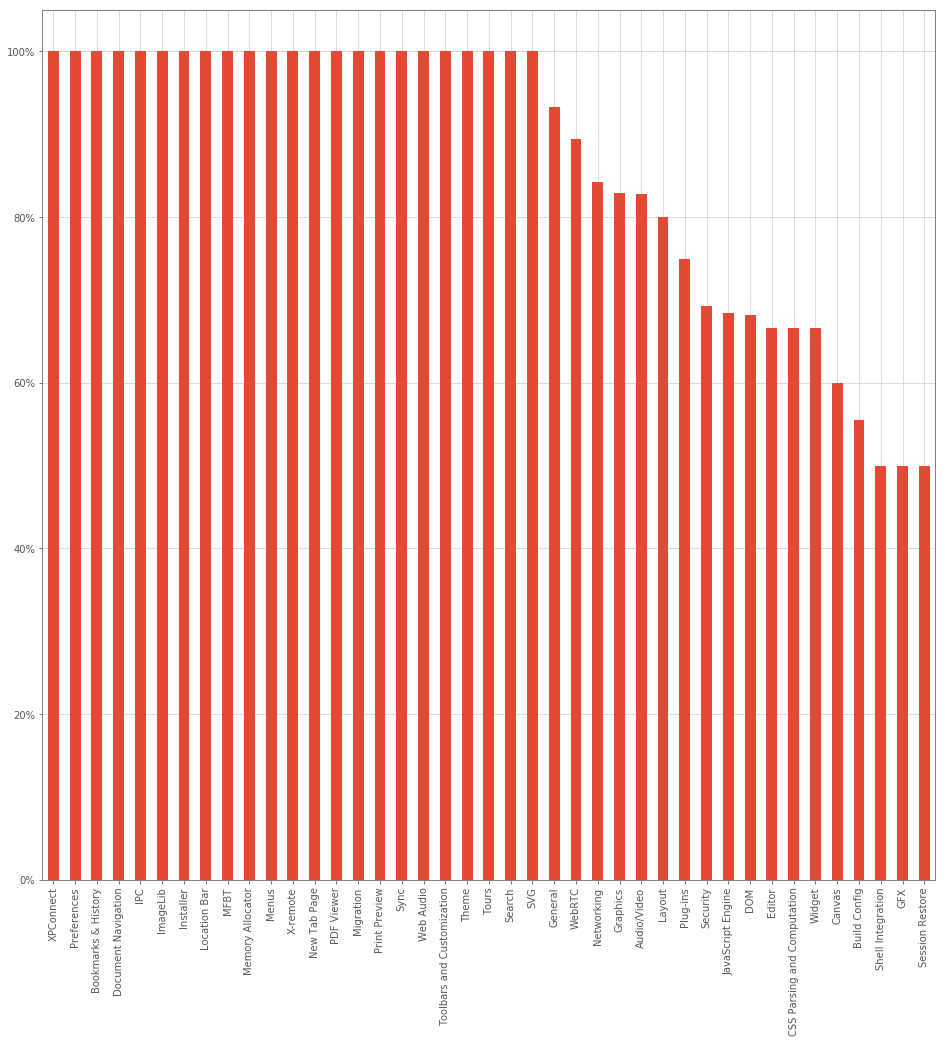

In [20]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_release[df_release['uplift_accepted'] == True].component.value_counts() / df_release.component.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per bug assignee

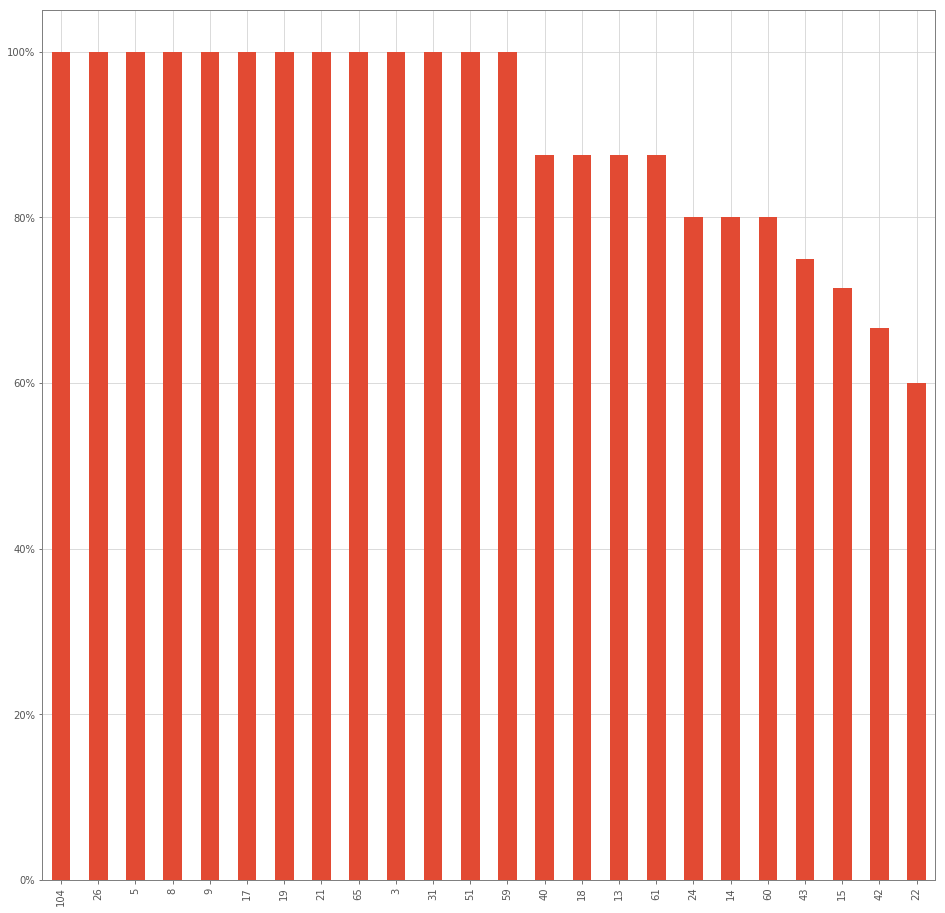

In [21]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_release[df_release['uplift_accepted'] == True].bug_assignee.value_counts().where(lambda x: x > 2) / df_release.bug_assignee.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per bug type

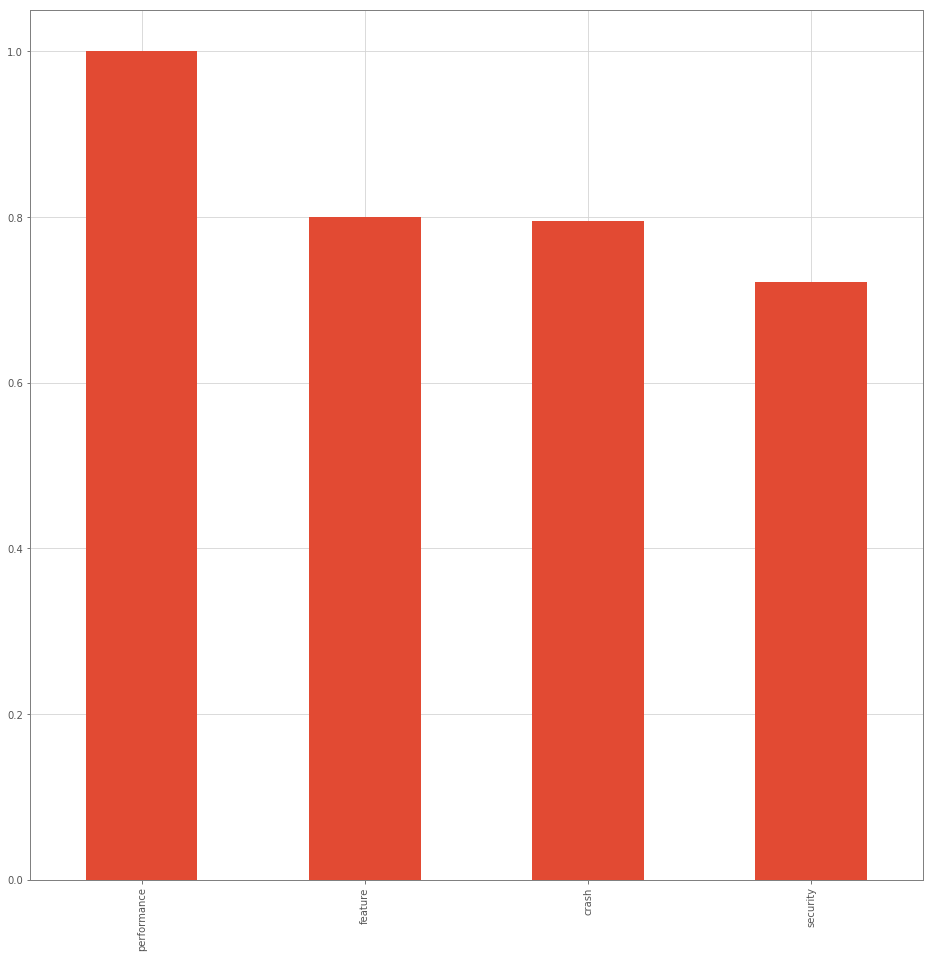

In [22]:
types = df_release.types.str.split('^').apply(pd.Series, 1).stack()
types.index = types.index.droplevel(-1)
types.name = 'Type'
types_approved = df_release[df_release['uplift_accepted'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_approved.index = types_approved.index.droplevel(-1)
types_approved.name = 'Type'

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
res = types_approved.value_counts() / types.value_counts()
res.sort_values(ascending=False).plot(kind='bar')
plt.show()

### Bug-inducing vs non-bug-inducing uplifts per component

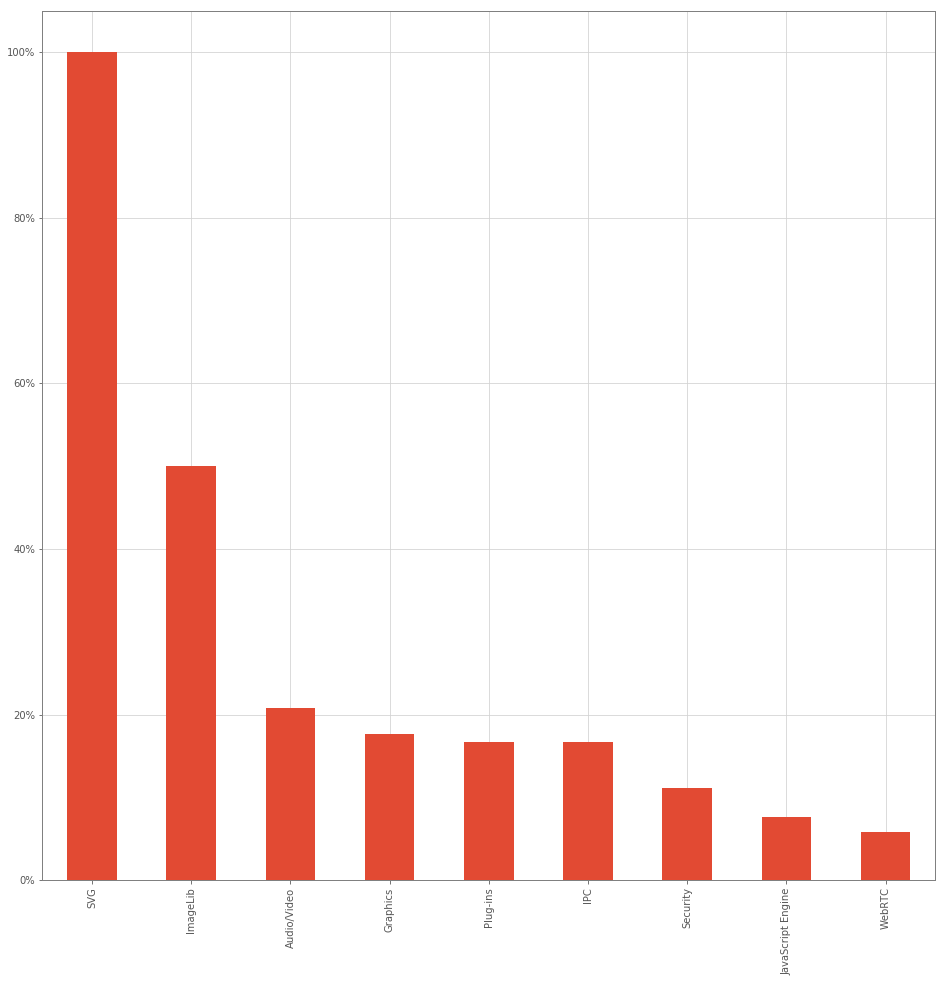

In [23]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_release_accepted[df_release_accepted['error_inducing'] == True].component.value_counts() / df_release_accepted.component.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar')
plt.show()

### Bug-inducing vs non-bug-inducing uplifts per bug type

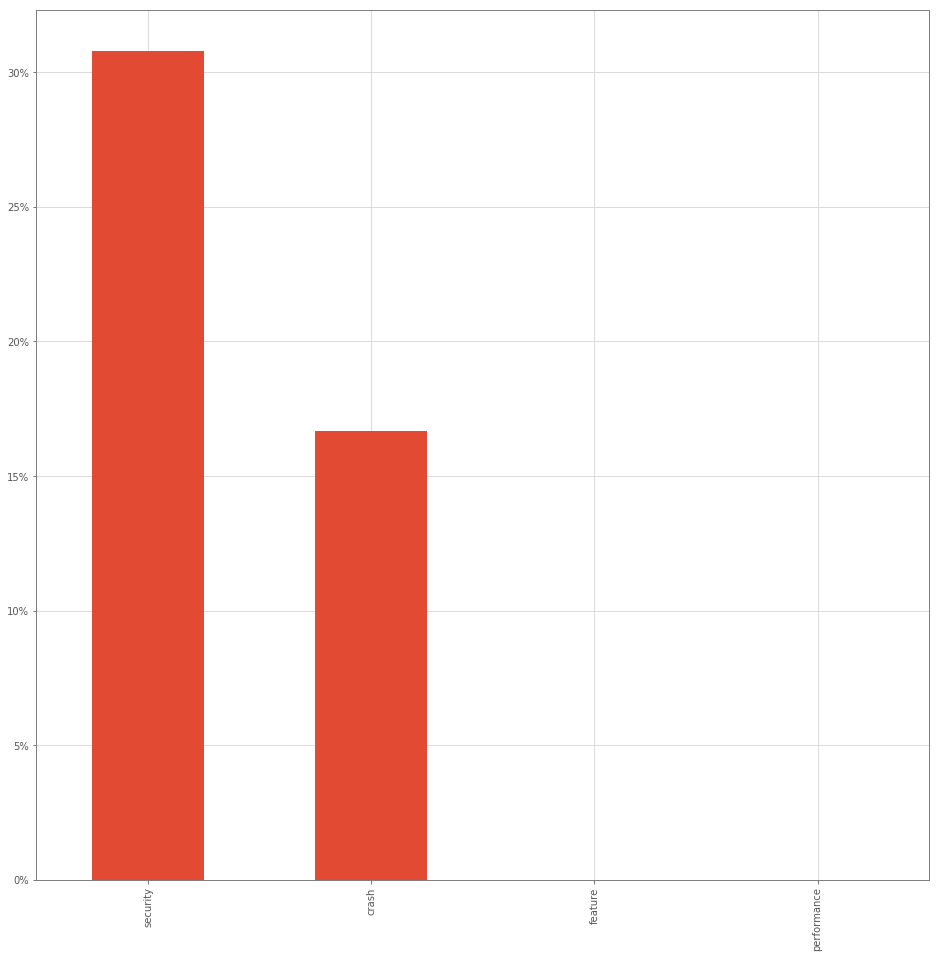

In [24]:
types = df_release_accepted.types.str.split('^').apply(pd.Series, 1).stack()
types.index = types.index.droplevel(-1)
types.name = 'Type'
types_bug_inducing = df_release_accepted[df_release_accepted['error_inducing'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_bug_inducing.index = types_bug_inducing.index.droplevel(-1)
types_bug_inducing.name = 'Type'

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = types_bug_inducing.value_counts() / types.value_counts()
res.sort_values(ascending=False).plot(kind='bar')
plt.show()

## Beta uplifts

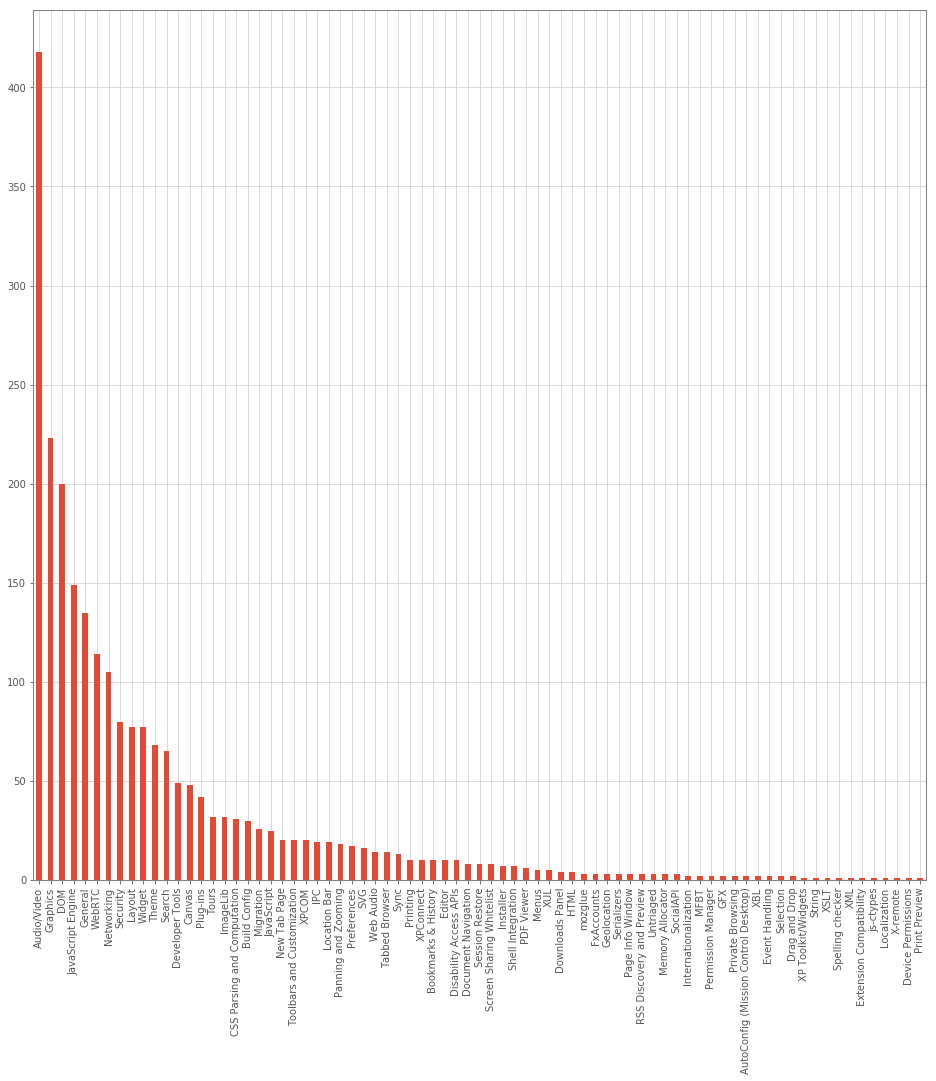

In [25]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
res = df_beta[df_beta['uplift_accepted'] == True].component.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per component

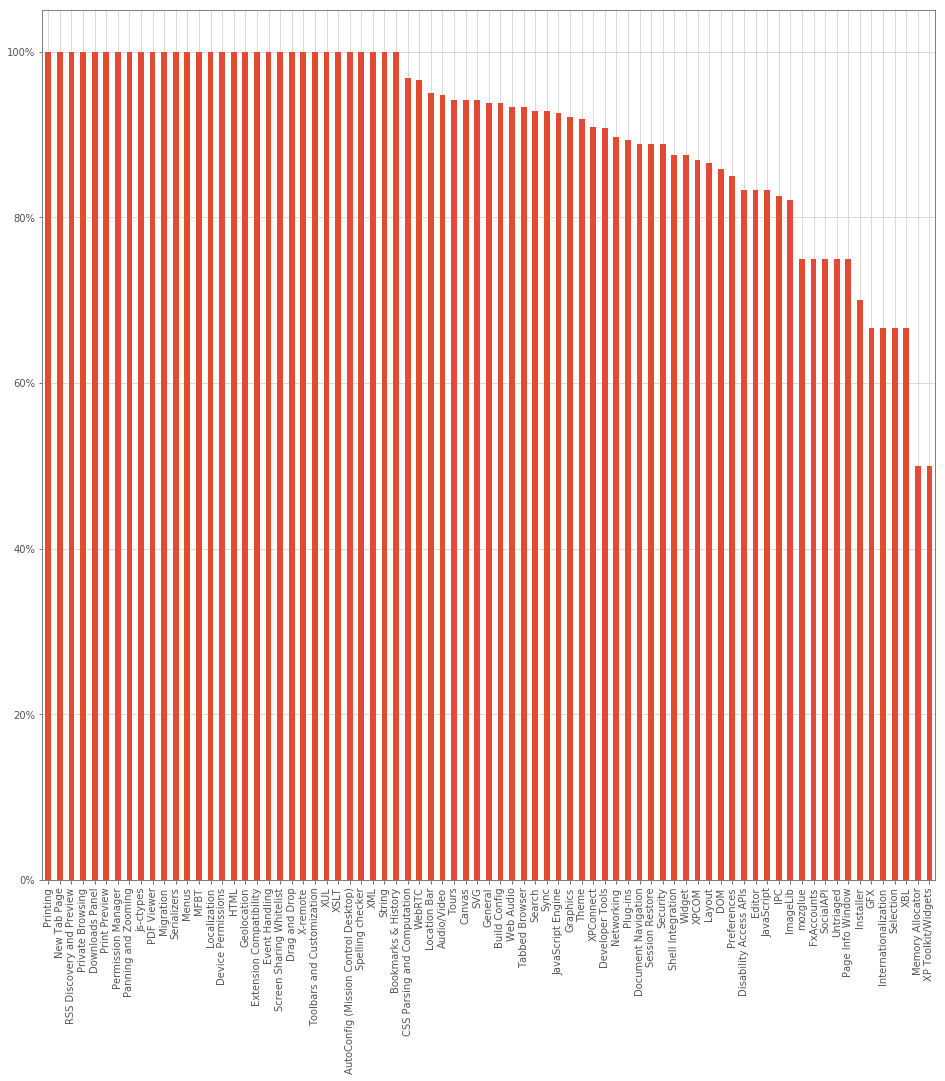

In [26]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_beta[df_beta['uplift_accepted'] == True].component.value_counts() / df_beta.component.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per bug assignee

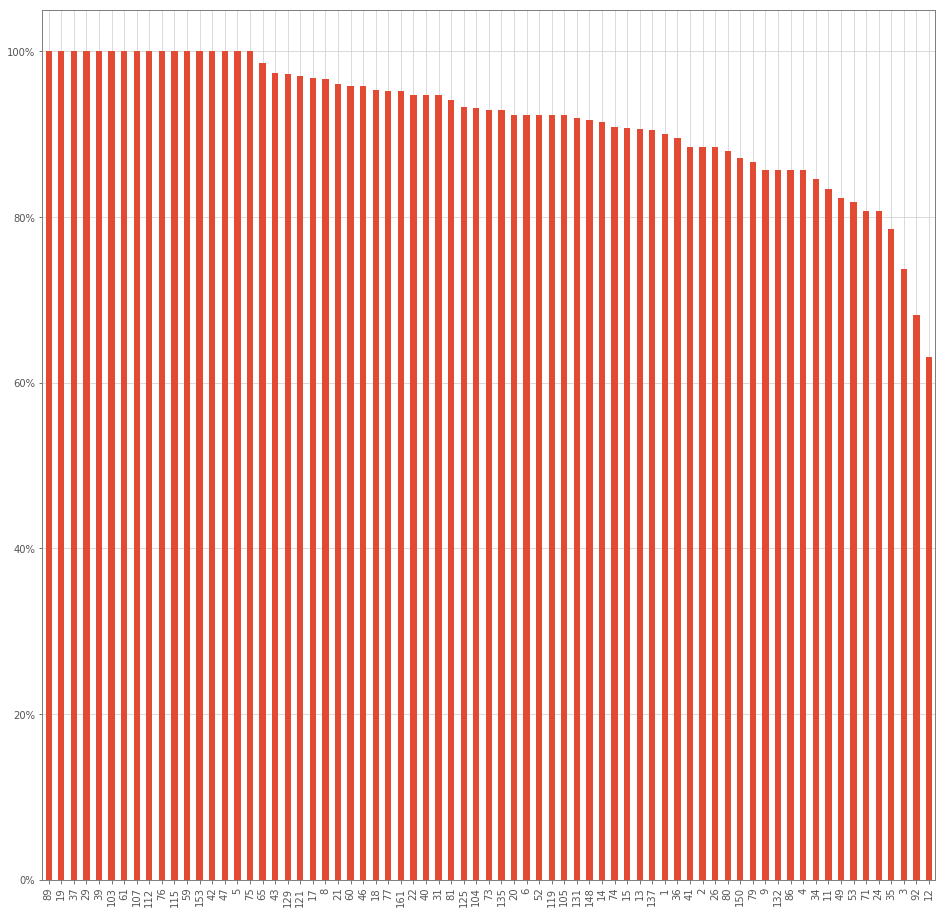

In [27]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_beta[df_beta['uplift_accepted'] == True].bug_assignee.value_counts().where(lambda x: x > 10) / df_beta.bug_assignee.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per bug type

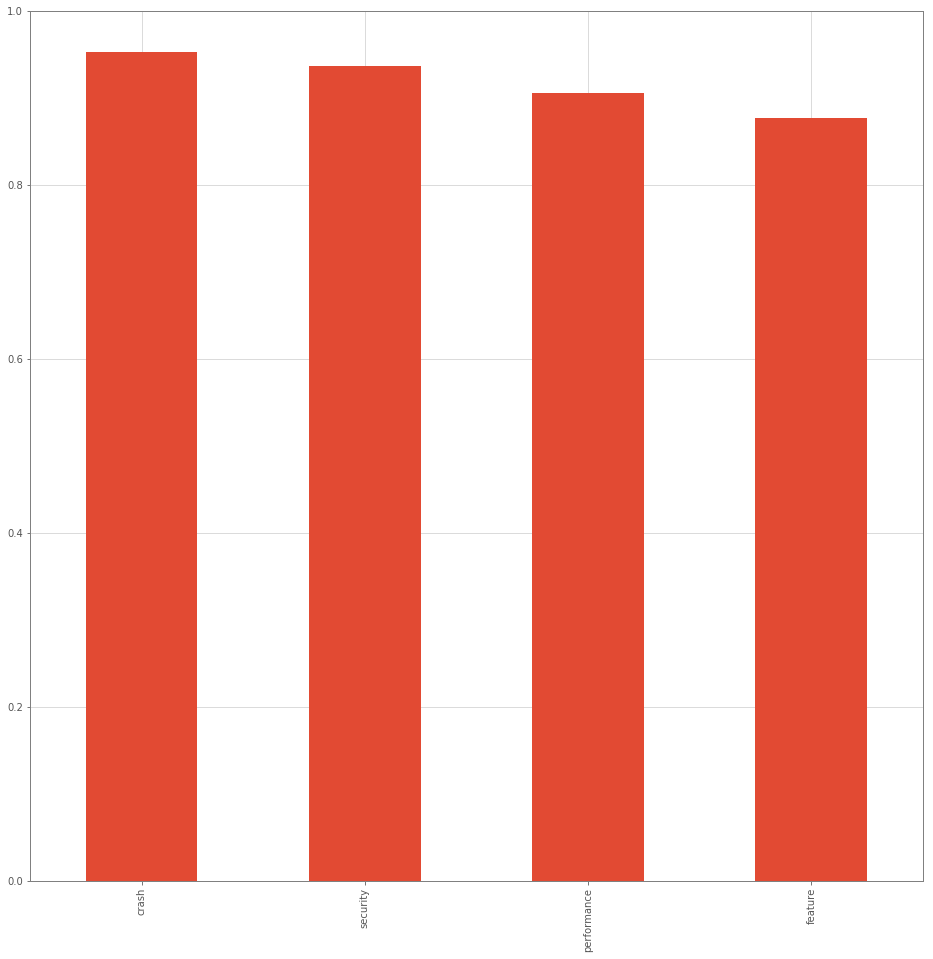

In [28]:
types = df_beta.types.str.split('^').apply(pd.Series, 1).stack()
types.index = types.index.droplevel(-1)
types.name = 'Type'
types_approved = df_beta[df_beta['uplift_accepted'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_approved.index = types_approved.index.droplevel(-1)
types_approved.name = 'Type'

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
res = types_approved.value_counts() / types.value_counts()
res.sort_values(ascending=False).plot(kind='bar')
plt.show()

### Bug-inducing vs non-bug-inducing uplifts per component

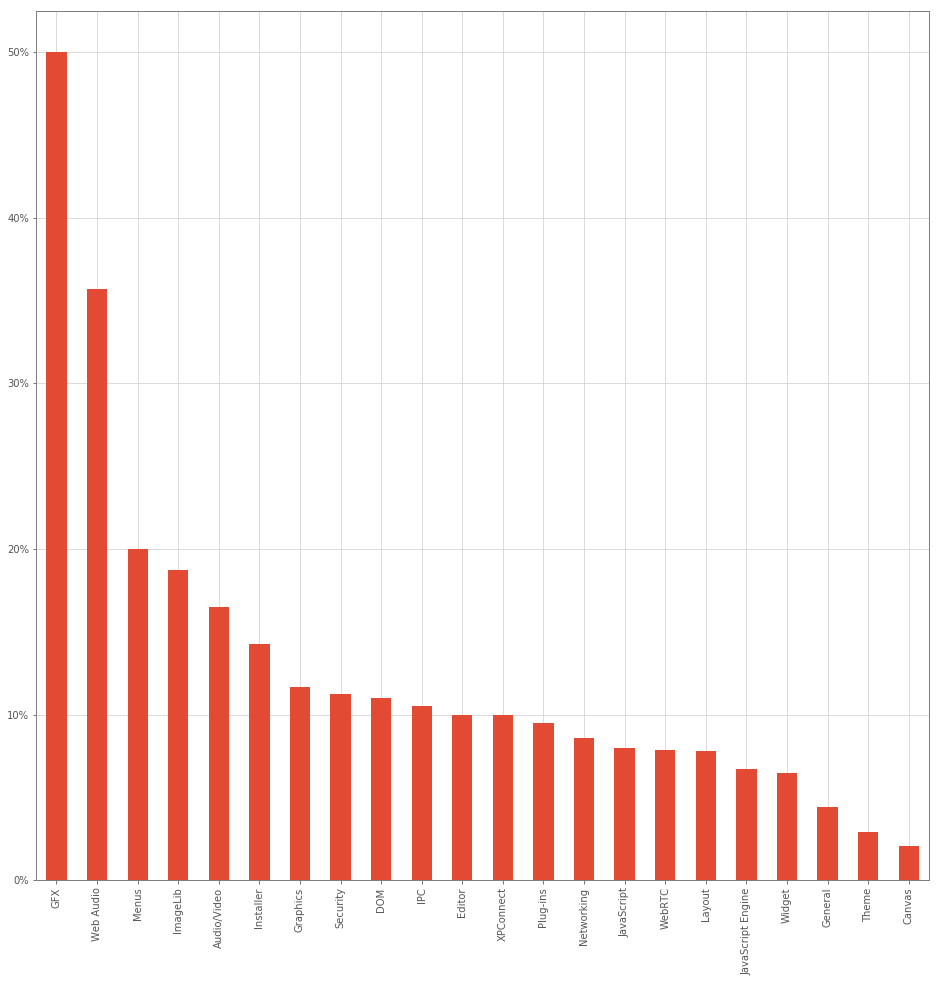

In [29]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_beta_accepted[df_beta_accepted['error_inducing'] == True].component.value_counts() / df_beta_accepted.component.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar')
plt.show()

### Bug-inducing vs non-bug-inducing uplifts per bug type

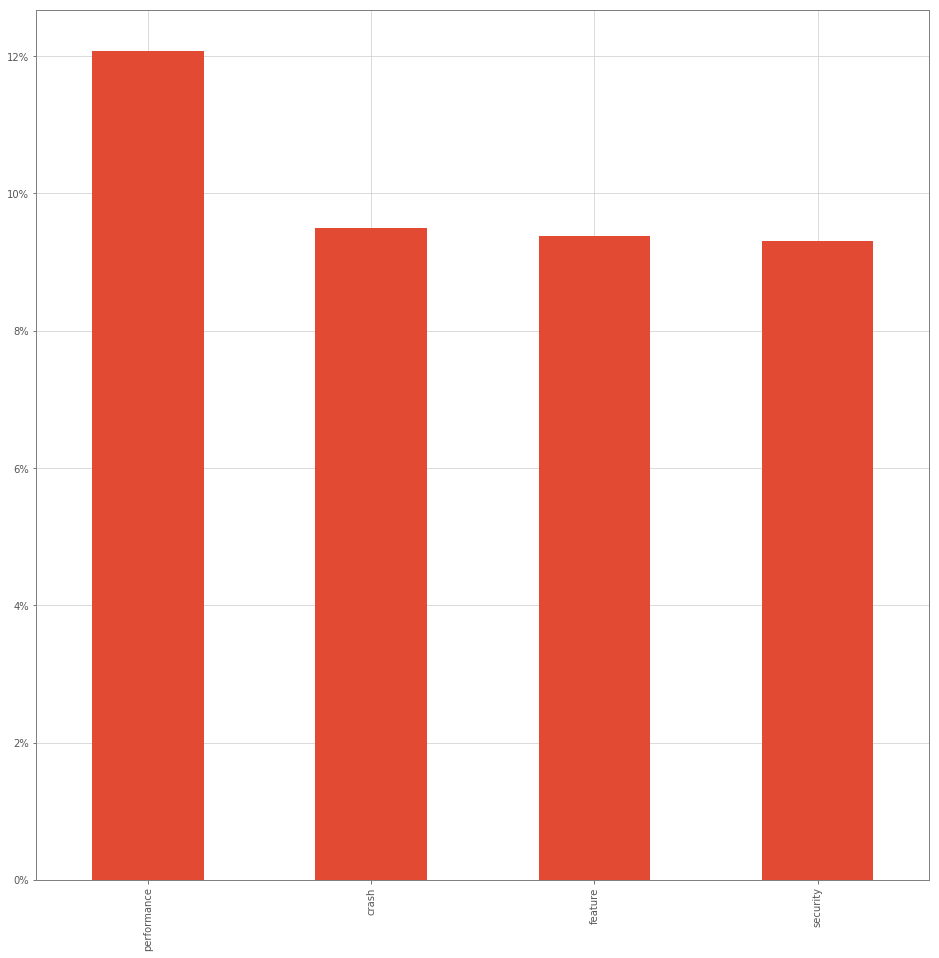

In [30]:
types = df_beta_accepted.types.str.split('^').apply(pd.Series, 1).stack()
types.index = types.index.droplevel(-1)
types.name = 'Type'
types_bug_inducing = df_beta_accepted[df_beta_accepted['error_inducing'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_bug_inducing.index = types_bug_inducing.index.droplevel(-1)
types_bug_inducing.name = 'Type'

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = types_bug_inducing.value_counts() / types.value_counts()
res.sort_values(ascending=False).plot(kind='bar')
plt.show()

## Aurora uplifts

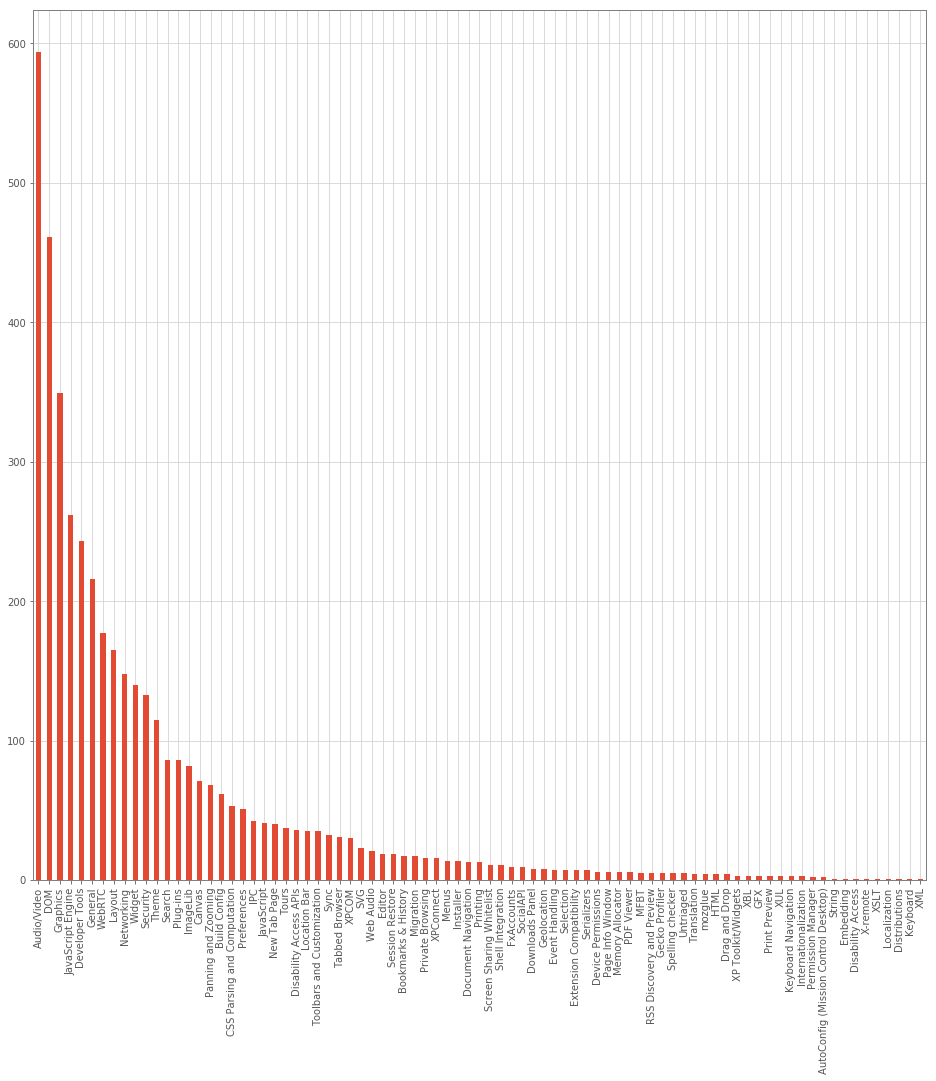

In [31]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
res = df_aurora[df_aurora['uplift_accepted'] == True].component.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per component

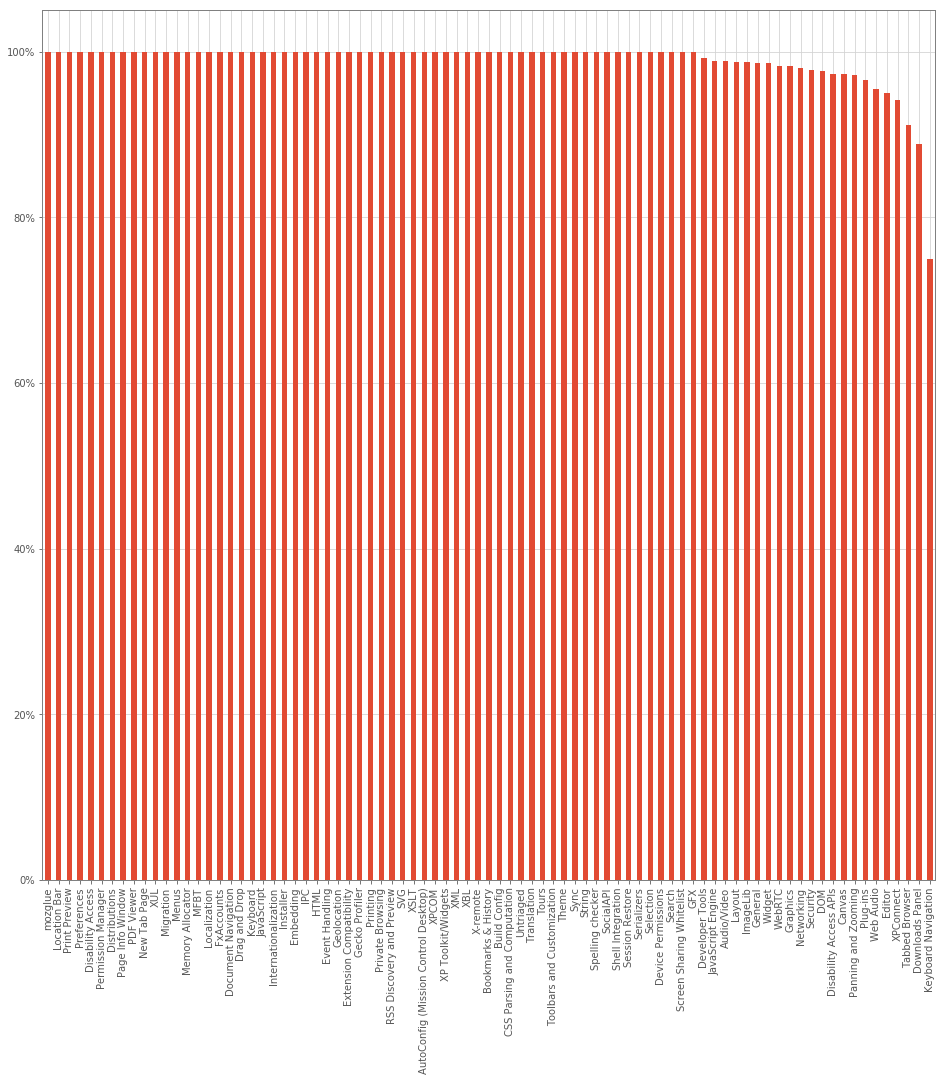

In [32]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_aurora[df_aurora['uplift_accepted'] == True].component.value_counts() / df_aurora.component.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per bug assignee

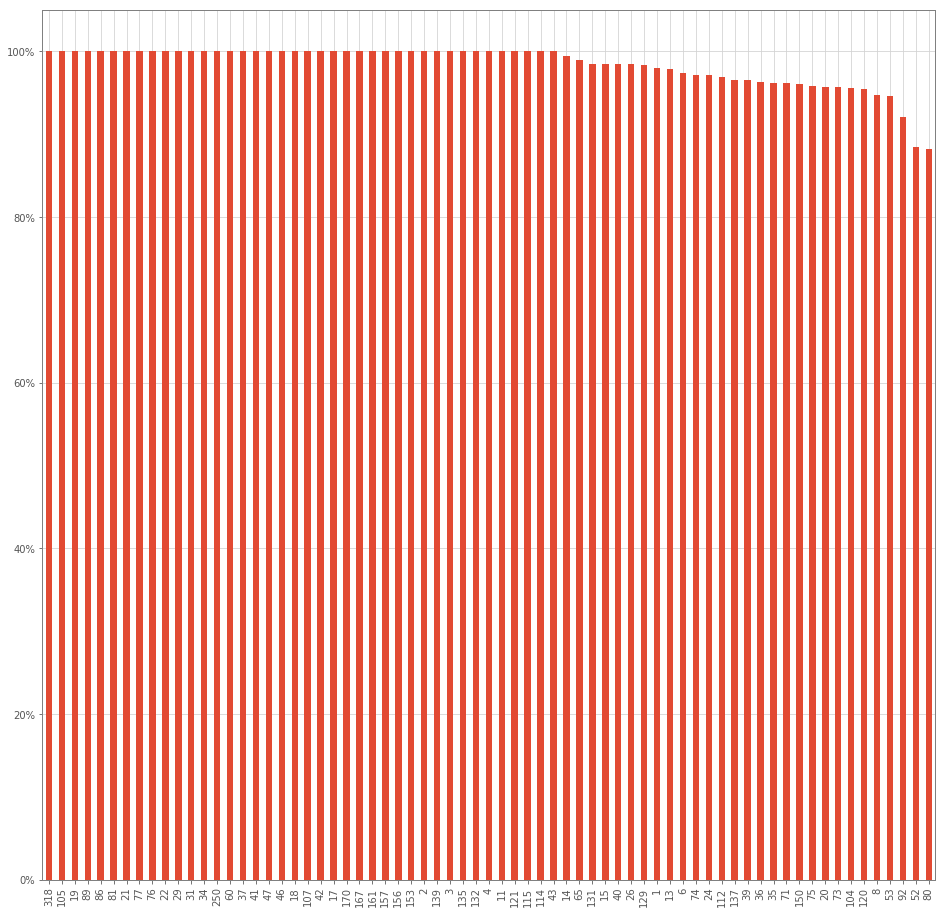

In [33]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_aurora[df_aurora['uplift_accepted'] == True].bug_assignee.value_counts().where(lambda x: x > 20) / df_aurora.bug_assignee.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per bug type

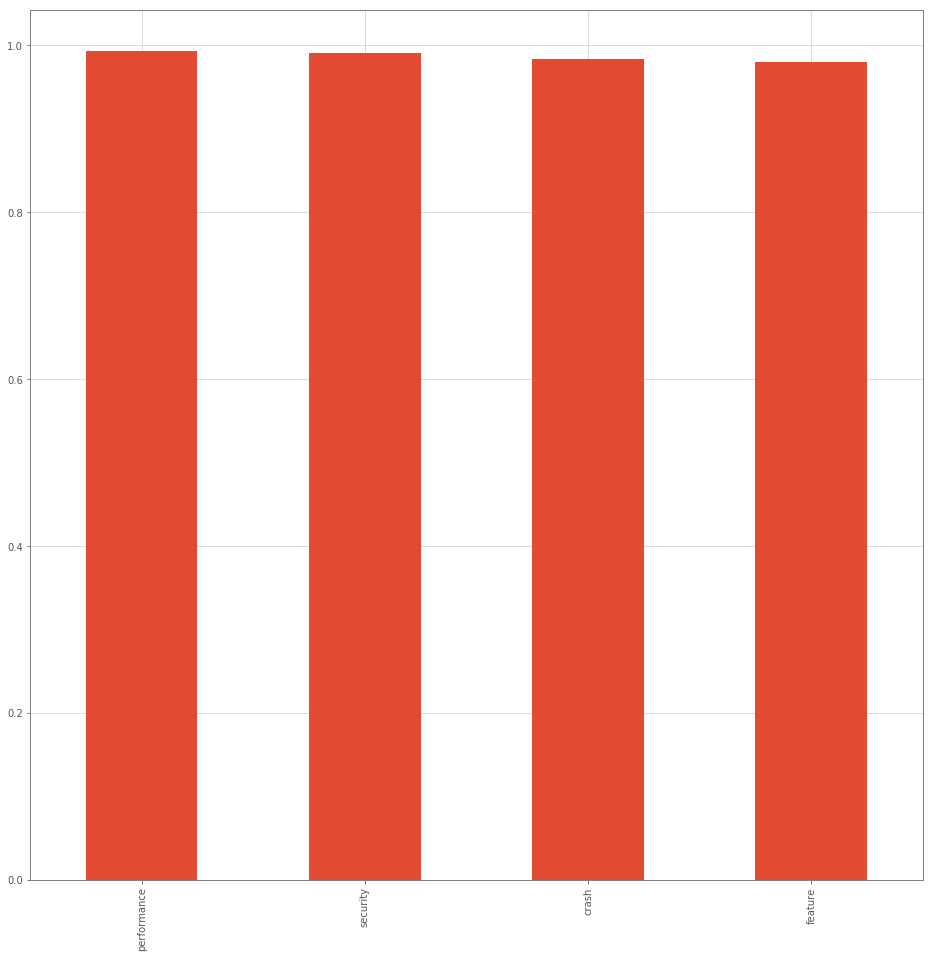

In [34]:
types = df_aurora.types.str.split('^').apply(pd.Series, 1).stack()
types.index = types.index.droplevel(-1)
types.name = 'Type'
types_approved = df_aurora[df_aurora['uplift_accepted'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_approved.index = types_approved.index.droplevel(-1)
types_approved.name = 'Type'

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
res = types_approved.value_counts() / types.value_counts()
res.sort_values(ascending=False).plot(kind='bar')
plt.show()

### Bug-inducing vs non-bug-inducing uplifts per component

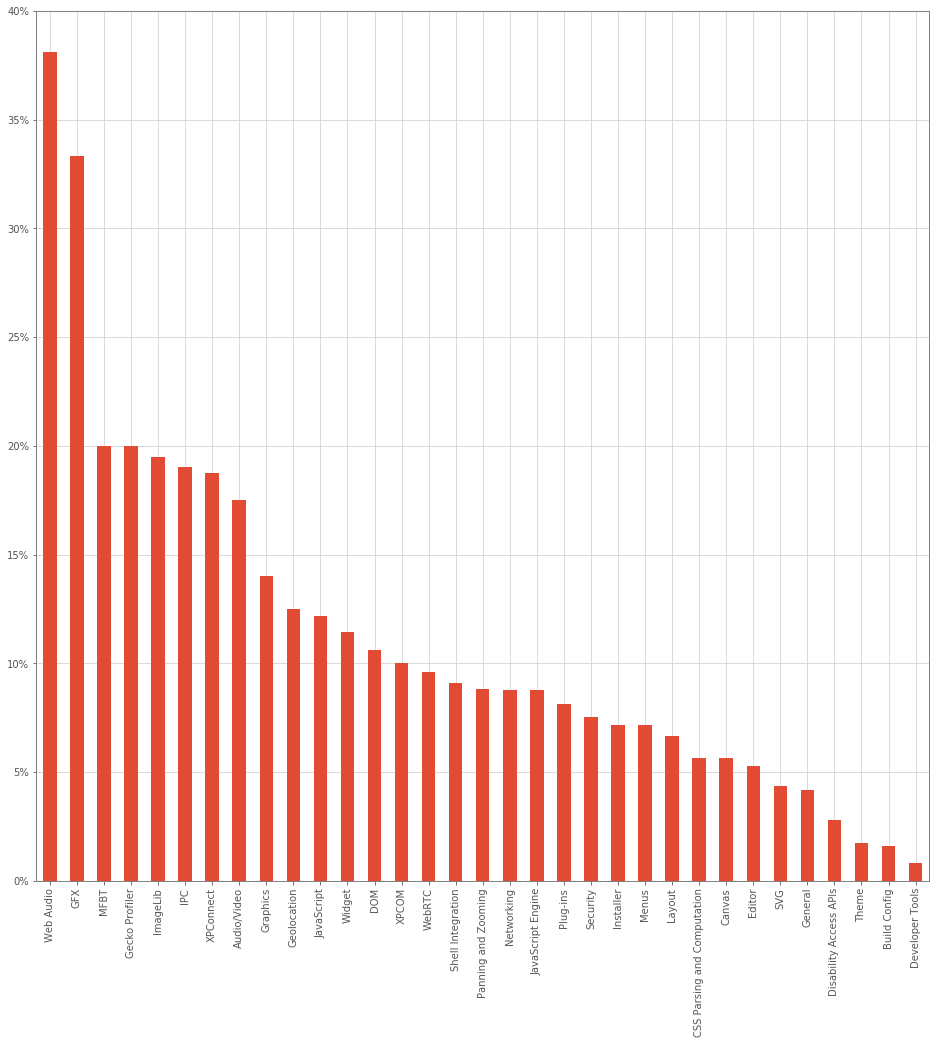

In [35]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_aurora_accepted[df_aurora_accepted['error_inducing'] == True].component.value_counts() / df_aurora_accepted.component.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar')
plt.show()

### Bug-inducing vs non-bug-inducing uplifts per bug type

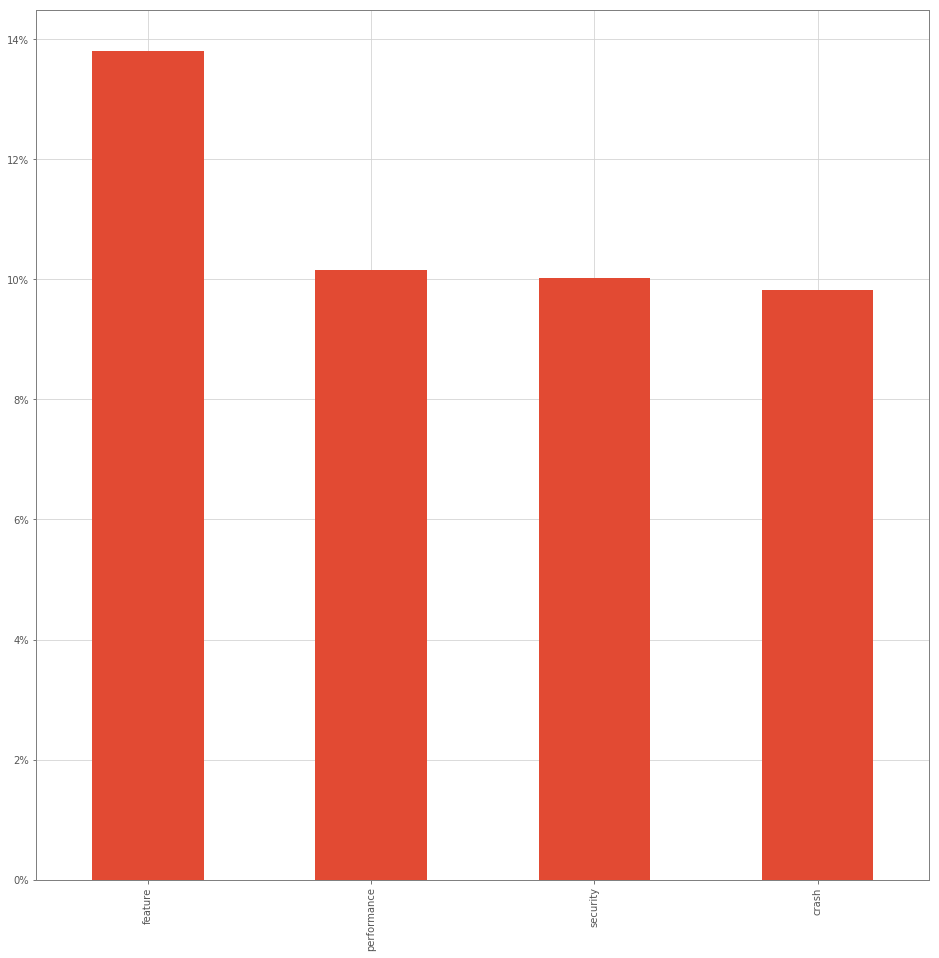

In [36]:
types = df_aurora_accepted.types.str.split('^').apply(pd.Series, 1).stack()
types.index = types.index.droplevel(-1)
types.name = 'Type'
types_bug_inducing = df_aurora_accepted[df_aurora_accepted['error_inducing'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_bug_inducing.index = types_bug_inducing.index.droplevel(-1)
types_bug_inducing.name = 'Type'

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = types_bug_inducing.value_counts() / types.value_counts()
res.sort_values(ascending=False).plot(kind='bar')
plt.show()